In [20]:
import time
import importlib

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow.keras import backend as K
from Modules import utils, tf_utils, plot_utils, models
from Modules.tf_utils import mae_cor, correlate

In [2]:
importlib.reload(utils)
importlib.reload(tf_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [32]:
with np.load('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.npz') as f:
    one_hot_yeast = {k: f[k] for k in f.keys() if k[:3] == 'chr'}
print(list(one_hot_yeast.keys()))

['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI']


In [45]:
# flanks = {'left': [], 'right': [], 'pos': []}
# for k, v in one_hot_yeast.items():
#     pos = np.random.randint(1000, len(v)-1000)
#     window = v[pos - 1000:pos+1000]
#     assert len(window) == 2000
#     assert window.sum() == 2000
#     window = np.argmax(window, axis=-1)
#     flanks['left'].append(window[:1000])
#     flanks['right'].append(window[1000:])
#     flanks['pos'].append(pos)
# for k, v in flanks.items():
#     flanks[k] = np.array(v)
# np.savez('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco_random1kbflanks_ACGTidx.npz', **flanks)

In [263]:
one_hot_rand = utils.random_sequences_as(one_hot_yeast, 10000, 2048, k=3)
one_hot_rand.shape

(10000, 2048, 4)

In [19]:
with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_pol_17/preds_mid_on_W303_Mmmyco.npz') as f:
    preds_pol = {k: f[k] for k in f.keys() if k[:3] == 'chr'}

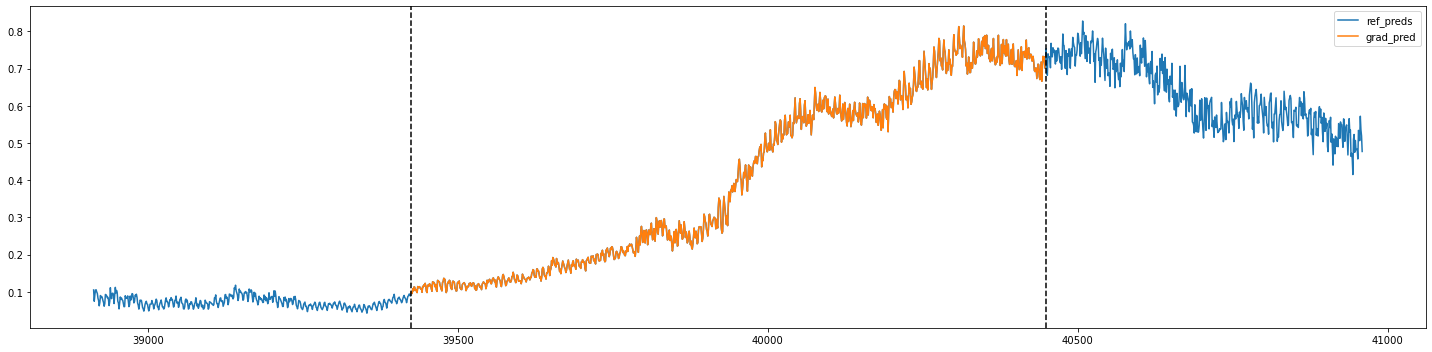

In [124]:
chr_id = 'chrIV'
start = 38912
stop = 40960
midlen = 128*8
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')
ax.plot(np.arange(start, stop), preds_pol[chr_id][start:stop], label='ref_preds')
ax.plot(np.arange(start + midlen//2, stop - midlen//2), preds_t, label='grad_pred')
sep = start + midlen - (start - midlen//2) % midlen
while sep < stop:
    ax.axvline(sep, color='k', linestyle='--')
    sep += midlen
ax.legend()

In [119]:
def get_gradients(model, one_hots, batch_size=1024, predict=False, head_start=0, n_heads=1):
    grads = np.empty(one_hots.shape, dtype='float32')
    n_batches = int(np.ceil((len(one_hots) / batch_size)))
    preds = None
    for i in range(n_batches):
        batch_start, batch_stop = i*batch_size, (i+1)*batch_size
        X = tf.Variable(one_hots[batch_start:batch_stop], dtype=tf.float32)
        with tf.GradientTape() as tape:
            Y = model(X, training=False)[:, head_start:head_start+n_heads]
        grads[batch_start:batch_stop] = np.array(tape.gradient(Y, X))
        if predict:
            Y = np.array(Y).squeeze()
            if i == 0:
                preds = np.empty((len(one_hots),) + Y.shape[1:],
                                 dtype='float32')
            preds[batch_start:batch_stop] = Y
    if predict:
        return grads.squeeze(), preds
    else:
        return grads.squeeze()

In [120]:
winsize = 2048
head_interval = 128
one_hots = utils.strided_sliding_window_view(
    one_hot_yeast[chr_id][start:stop+head_interval-1],
    (winsize, 4),
    winsize//2,
    head_interval).reshape(-1, winsize, 4)
one_hots.shape

(128, 2048, 4)

In [121]:
grads, preds = get_gradients(model_pol, one_hots, predict=True, head_start=4, n_heads=8)
preds_t = preds.T.ravel()
print(preds.shape)

(128, 8)


In [125]:
print(grads.shape)
grads_proj = grads - grads.mean(axis=-1, keepdims=True)
print(grads_proj.shape)
grads_seq = grads[one_hots].reshape(grads.shape[:-1])
print(grads_seq.shape)
grads_proj_seq = grads_proj[one_hots].reshape(grads.shape[:-1])
print(grads_proj_seq.shape)

(128, 2048, 4)
(128, 2048, 4)
(128, 2048)
(128, 2048)


<AxesSubplot:>

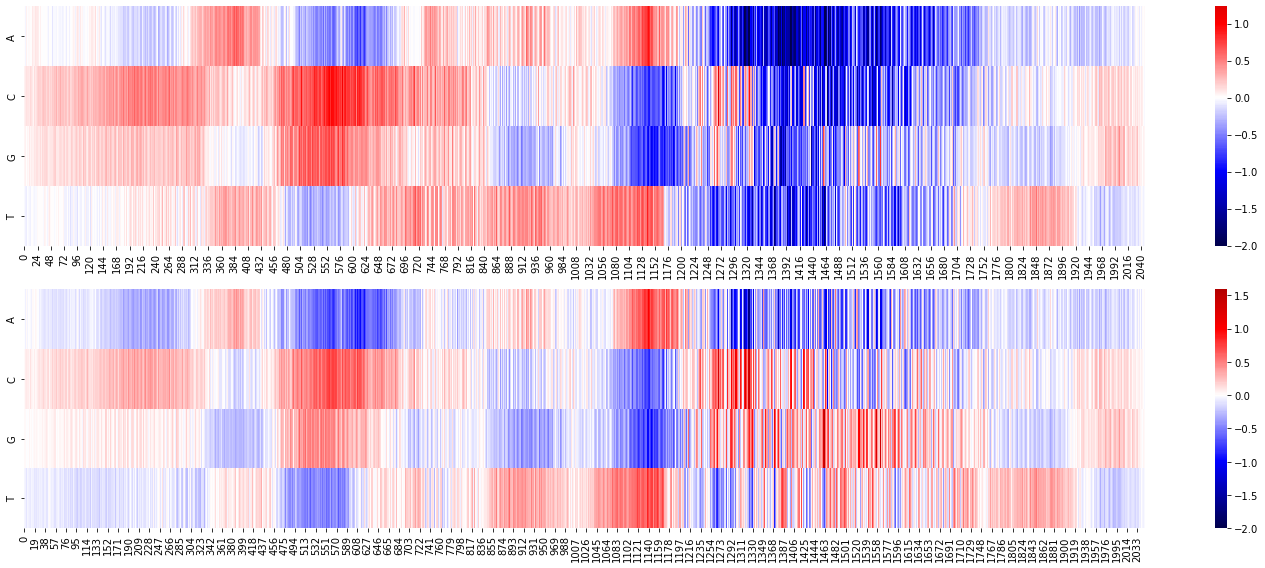

In [129]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight')
# sns.heatmap(grads_proj[0].T, ax=ax, cmap='seismic', center=0)
vmin = -2
sns.heatmap(grads.sum(axis=0).T, cmap='seismic', center=0, vmin=vmin, ax=axes[0],# cbar_ax=axes[0, 1],
            yticklabels=list('ACGT'))
sns.heatmap(grads_proj.sum(axis=0).T, cmap='seismic', center=0, vmin=vmin, ax=axes[1],# cbar_ax=axes[0, 1],
            yticklabels=list('ACGT'))

In [21]:
model_pol_name = 'model_myco_pol_17'
# with tf.distribute.MirroredStrategy().scope():
model_pol = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_pol_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_nuc_name = 'model_myco_nuc_2'
model_nuc = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_nuc_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_coh_name = 'model_myco_coh_14'
model_coh = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_coh_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_rna_name = 'weight_CNN_RNA_seq_2001_12_8_4_SRR7131299' # order 'ATGC'
model_rna = tf.keras.models.load_model(f'/home/alex/shared_folder/JB_seqdes/{model_rna_name}.hdf5',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_rna.input_shape

2023-10-18 14:17:25.475562: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-10-18 14:17:25.553371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 14:17:25.553527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-10-18 14:17:25.553572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 14:17:25.553688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

(None, 2001, 4, 1)

In [22]:
from kMC_sequence_design import rmse, GC_energy

def energy_parser_v2(file):
    energies = np.loadtxt(file)
    with open(file, 'r') as f:
        n_seqs = 0
        for line in f:
            if n_seqs != 0 and line.startswith('#'):
                break
            if not line.startswith('#'):
                n_seqs += 1
    return np.transpose(energies.reshape(-1, n_seqs, energies.shape[1]), [1, 0, 2])

(2, 500, 5)
(2, 500, 5)
(2, 500, 5)


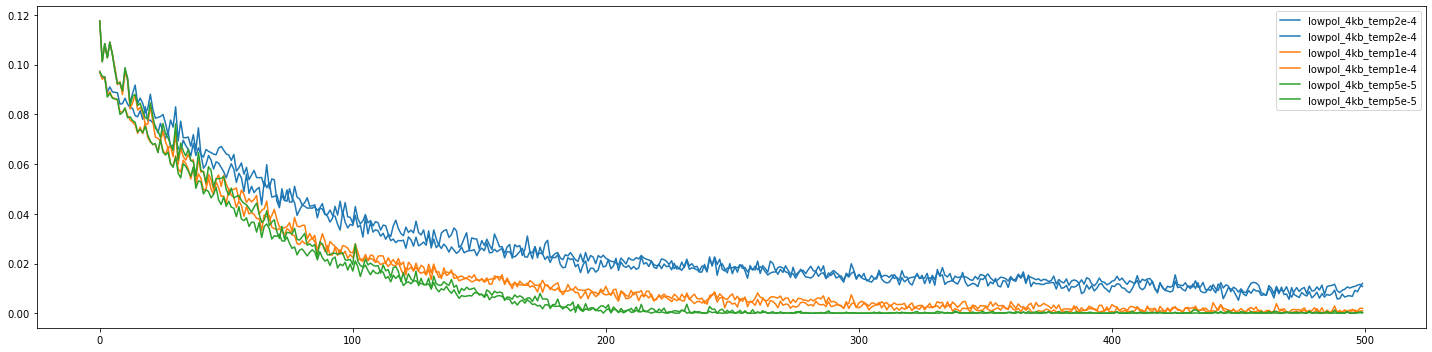

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')#, sharey=True)
temps = ['2e-4', '1e-4', '5e-5']
exp_ids = [f'lowpol_4kb_temp{t}' for t in temps]# + [f'highpol_4kb_temp{t}_mid' for t in temps] # [f'test{n}' for n in range(90, 91)]
exp_labels = exp_ids # [f'4kb_temp{t}_mid' for t in temps]
for exp_id, exp_lab, color in zip(exp_ids, exp_labels, colors):
    # if exp_id.startswith('highpol') and exp_id[-8:-4] in ['1e-4', '5e-5']:
    #     continue
    energies = energy_parser_v2(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/energy.txt')
    print(energies.shape)
    ax.plot(energies[:2, :, 0].T, label=exp_lab, color=color)
ax.legend()
# ax.set_ylim((-0.001, 2))

(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)


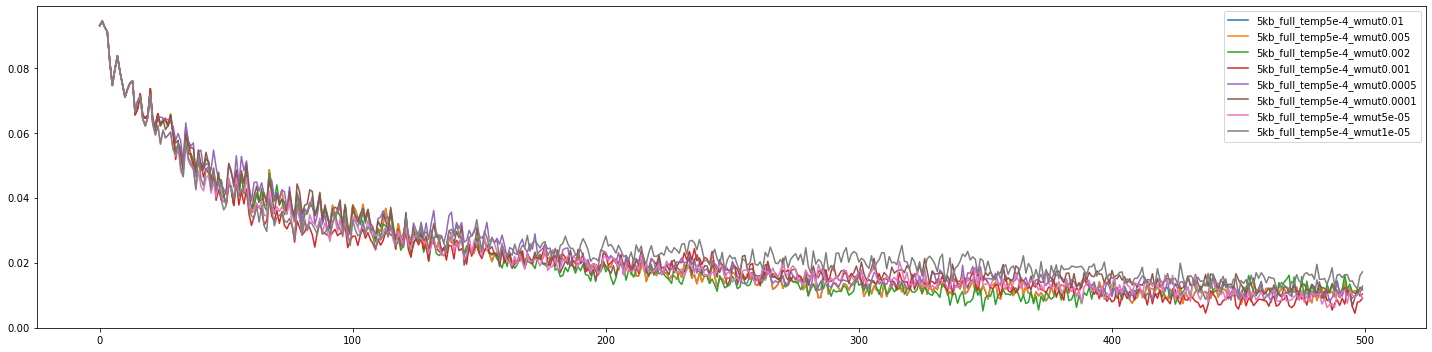

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')#, sharey=True)
exp_ids = [f'test{n}' for n in range(49, 57)]
wmuts = [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
exp_labels = [f'5kb_full_temp5e-4_wmut{w}' for w in wmuts]
for exp_id, exp_lab, color in zip(exp_ids, exp_labels, colors):
    energies = energy_parser_v2(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/energy.txt')
    print(energies.shape)
    ax.plot(energies[:1, :, 0].T, label=exp_lab, color=color)
ax.legend()

(2, 12000)


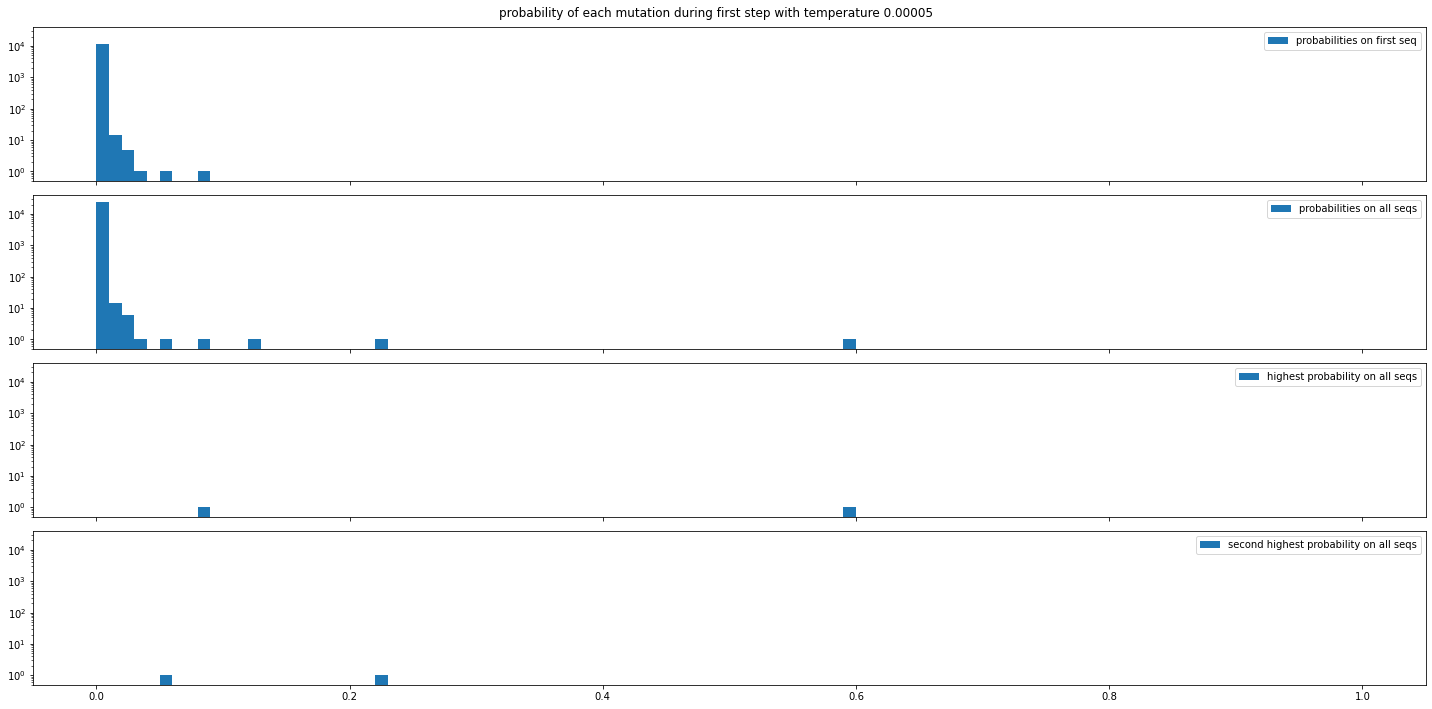

In [25]:
exp_name = 'lowpol_4kb_temp2e-4'
i = 0
probs = np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/probs/prob_step{i}.npy')
print(probs.shape)
probs = np.sort(probs, axis=1)
fig, axes = plt.subplots(4, 1, figsize=(20, 10), facecolor='w', layout='tight', sharey=True, sharex=True)
fig.suptitle('probability of each mutation during first step with temperature 0.00005')
axes[0].hist(probs[0], bins=100, range=(0, 1), label='probabilities on first seq')
axes[1].hist(probs.ravel(), bins=100, range=(0, 1), label='probabilities on all seqs')
axes[2].hist(probs[:, -1], bins=100, range=(0, 1), label='highest probability on all seqs')
axes[3].hist(probs[:, -2], bins=100, range=(0, 1), label='second highest probability on all seqs')
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(bottom=5e-1)
    ax.legend()
plt.show()

In [26]:
exp_name = 'lowpol_4kb_temp2e-4'
probs = []
energies = energy_parser_v2(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/energy.txt')
for i in range(energies.shape[1]):
    probs.append(np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/probs/prob_step{i}.npy'))
probs = np.stack(probs, axis=1)
print(probs.shape)
probs = np.sort(probs, axis=-1)

(2, 500, 12000)


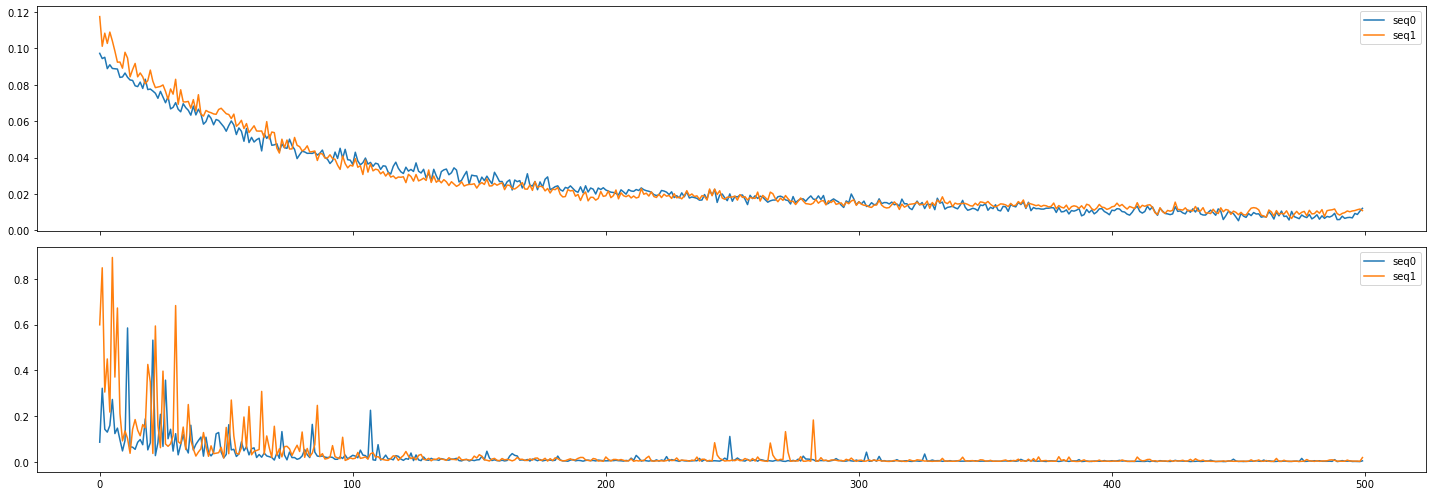

In [27]:
start = 0
stop = 2
fig, axes = plt.subplots(2, 1, figsize=(20, 7), facecolor='w', layout='tight', sharex=True)
axes[0].plot(energies[start:stop, :, 0].T, label=[f'seq{i}' for i in range(start, stop)])
axes[1].plot(probs[start:stop, :, -1].T, label=[f'seq{i}' for i in range(start, stop)])
for ax in axes:
    ax.legend()
plt.show()

In [ ]:
n = 100
l = 2175
freq_kmers = pd.read_csv('/home/alex/shared_folder/SCerevisiae/genome/W303/W303_3mer_freq.csv', index_col=[0, 1, 2])
np.random.seed(0)
seqs = utils.random_sequences(n, l, freq_kmers.iloc[:, 0], out='idx')

In [45]:
exp_name = 'lowpol_4kb_temp2e-4'
seqs = [np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/start_seqs.npy')]
for i in range(500):
    seqs.append(np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/mut_seqs_step{i}.npy'))
seqs = np.stack(seqs, axis=1)
print(seqs.shape)

(2, 501, 4000)


In [ ]:
# start_seqs = np.load(f'/home/alex/shared_folder/SCerevisiae/generated/test9/start_seqs.npy')
# np.save('/home/alex/shared_folder/SCerevisiae/generated/test9/start_seqs_first1.npy', start_seqs[:1])

In [ ]:
with np.load('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco_random1kbflanks_ACGTidx.npz') as f:
    flank_left = f['left']
    flank_right = f['right']

In [67]:
import kMC_sequence_design
importlib.reload(tf_utils)
importlib.reload(kMC_sequence_design)
from kMC_sequence_design import get_profile_hint, get_profile_mid1
from Modules.tf_utils import get_profile

In [49]:
preds = get_profile_hint(seqs, model_pol, 2048, 128, middle=True)
preds_rev = get_profile_hint(seqs, model_pol, 2048, 128, reverse=True, middle=True)
# preds = get_profile_mid1(seqs, model_rna, 2001, one_hot_converter=lambda x: np_idx_to_one_hot(x, order='ATGC', extradims=-1))
# preds_rev = get_profile_mid1(seqs, model_rna, 2001, reverse=True, one_hot_converter=lambda x: np_idx_to_one_hot(x, order='ATGC', extradims=-1))
loss = rmse(np.zeros(preds.shape[:-1] + (1,)), preds)
loss_rev = rmse(np.zeros(preds.shape[:-1] + (1,)), preds_rev)
gc_energy = GC_energy(seqs, 0.3834)

2023-10-18 11:50:20.186296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-10-18 11:50:20.204271: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2023-10-18 11:50:20.373862: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-10-18 11:50:20.672491: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-10-18 11:50:20.996384: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-18 11:50:20.996407: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2023-10-18 11:50:20.996699: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-18 11:50:20.996748: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

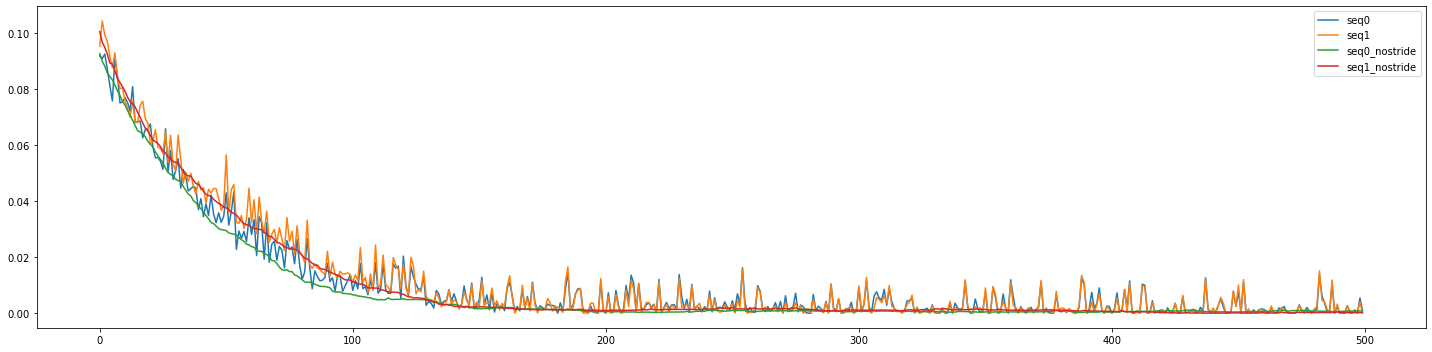

In [51]:
energies = energy_parser_v2(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/energy.txt')
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')
ax.plot(energies[:2, :, 0].T, label=[f'seq{i}' for i in range(2)])
for idx in range(len(seqs)):
    ax.plot(gc_energy[idx, 1:] + loss[idx, 1:] + loss_rev[idx, 1:], label=f'seq{idx}_nostride')
ax.legend()

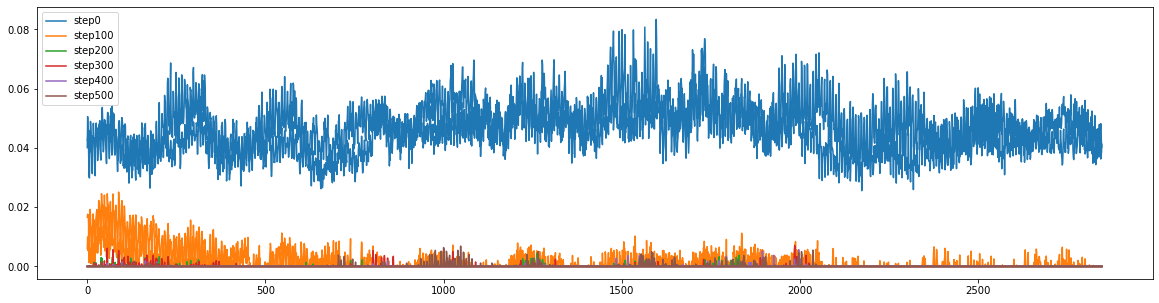

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w')
for i, color in zip(range(0, 501, 100), colors):
    ax.plot(preds[0, i, :], label=f'step{i}', color=color)
    ax.plot(preds_rev[0, i, :], color=color)
ax.legend()

In [ ]:
to_predict = seqs[:, ::100]
print(to_predict.shape)
preds = get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=None)
preds_rev = get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=None, reverse=True)
preds_flanks = []
preds_flanks_rev = []
for i in range(len(flank_left)):
    flanks=(flank_left[i], flank_right[i])
    preds_flanks.append(get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=flanks))
    preds_flanks_rev.append(get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=flanks, reverse=True))

In [69]:
print(preds.shape, preds_rev.shape)
print(preds_flanks[0].shape, preds_flanks_rev[0].shape)

((2, 6, 2849), (2, 6, 2849))

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20, 12), facecolor='w', layout='tight', sharex=True, sharey=True)
seq_idx = 0
for i in range(0, 6, 5):
    step = i*100
    color = colors[i]
    for ax, pfor, prev in zip(axes.flatten(), preds_flanks, preds_flanks_rev):
        ax.plot(pfor[seq_idx, i, :], color=color, label=f'step{step}')
        ax.plot(-prev[seq_idx, i, :], color=color)
axes[0, 0].legend()

In [53]:
to_predict = seqs[:, ::100]
print(to_predict.shape)
preds_pol = get_profile_hint(to_predict, model_pol, 2048, 128)#, middle=False)
preds_pol_rev = get_profile_hint(to_predict, model_pol, 2048, 128, reverse=True)#, middle=False)
preds_nuc = get_profile(to_predict, model_nuc, 2001)
preds_nuc_rev = get_profile(to_predict, model_nuc, 2001, reverse=True)
preds_rna = get_profile(to_predict, model_rna, 2001, one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order='ATGC', extradims=-1))
preds_rna_rev = get_profile(to_predict, model_rna, 2001, reverse=True, one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order='ATGC', extradims=-1))

(2, 6, 4000)


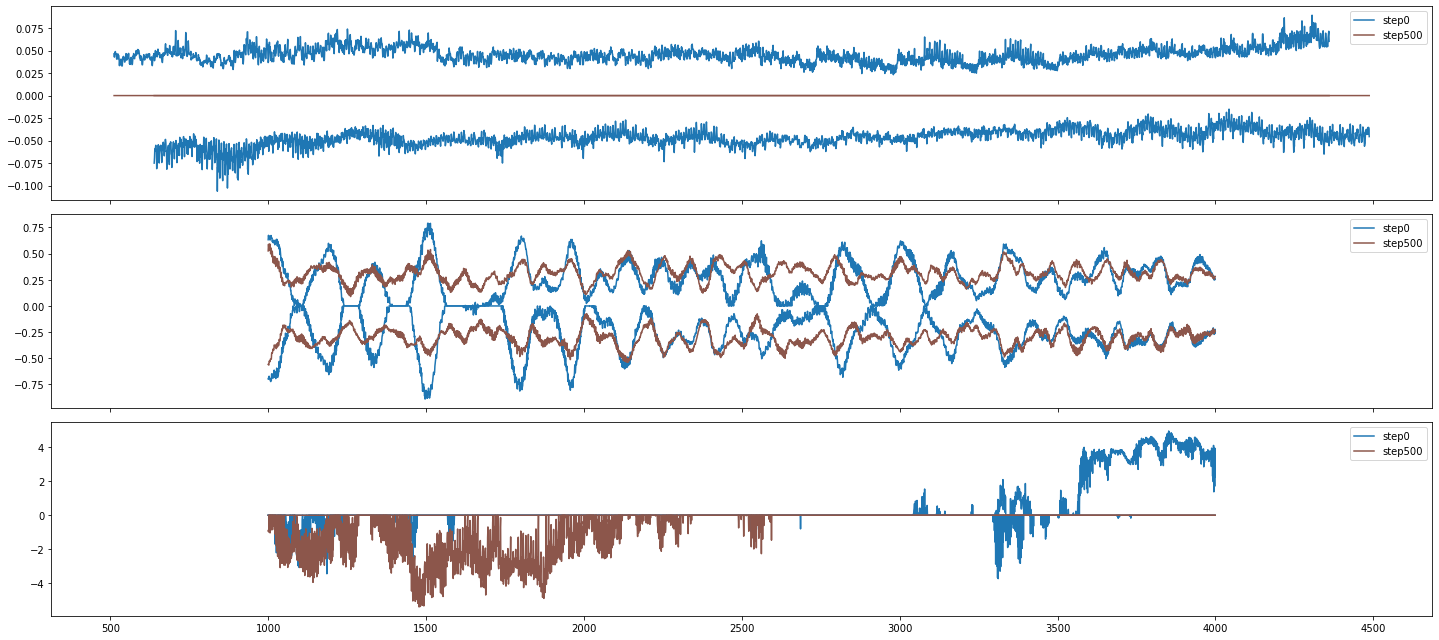

In [16]:
length = to_predict.shape[-1]
seq_idx = 0
fig, axes = plt.subplots(3, 1, figsize=(20, 9), facecolor='w', layout='tight', sharex=True)
for i in range(0, 6, 5):
    step = i*100
    color = colors[i]
    axes[0].plot(np.arange(128*4, 128*4+preds_pol.shape[-1]), preds_pol[seq_idx, i, :], color=color, label=f'step{step}')
    axes[0].plot(np.arange(length-128*4-preds_pol.shape[-1], length-128*4), -preds_pol_rev[seq_idx, i, :], color=color)
    axes[1].plot(np.arange(1000, length - 1000), preds_nuc[seq_idx, i, :], color=color, label=f'step{step}')
    axes[1].plot(np.arange(1000, length - 1000), -preds_nuc_rev[seq_idx, i, :], color=color)
    axes[2].plot(np.arange(1000, length - 1000), preds_rna[seq_idx, i, :], color=color, label=f'step{step}')
    axes[2].plot(np.arange(1000, length - 1000), -preds_rna_rev[seq_idx, i, :], color=color)
for ax in axes:
    ax.legend()

Checking model and sequences

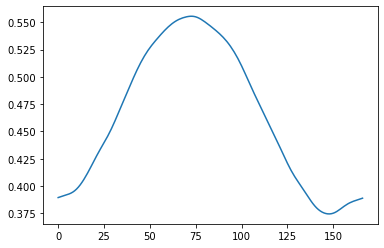

In [4]:
from sklearn.neighbors import KernelDensity
import h5py

def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):  
    """ 
        Take a numpy array and return a view of this array after applying a rolling window.

        This takes a numpy and cut it in several pieces with the size, the stride and the 
        axes asked as needed. You may want to use it in order to create a set of sequences
        from an array.

        :param array: The array we want to cut
        :param window: The length of the window
        :param asteps: The stride between two window applied
        :param wsteps: The stride whitin the window
        :param axes: The axe on which to apply the rolling window
        :param toend: Weither or not to finish the cut
        :type array: numpy array
        :type window: int or tuple
        :type asteps: int or tuple
        :type wsteps: int or tuple
        :type axes: int
        :type toend: boolean
        :return: The view of the array
        :rtype: numpy array

        :Example:

        >>> a = numpy.array([0,1,2,3,4,5])
        >>> rolling_window(a, window = 2, asteps = 2, wsteps = None)
        array([[0,1],
               [2,3],
               [4,5]])
        >>> rolling_window(a, window = 2, asteps = None, wsteps = 2)
        array([[0,2],
               [1,3],
               [2,4]
               [3,5]])
        >>> rolling_window(a, window = 5, asteps = 2, wsteps = None)
        array([[0,1,2,3,4]])

        .. warning:: Be carreful about the combination of window, wsteps and asteps that may raise 
                     ValueError. This function forces the window to be of the asked size and thus 
                     may stop the application of the window before the end.
    """        

    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger than 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger than the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any \"old\" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtypenucleotid=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)


def process_input(nucleotid, repeat=1, dummy=3):
    window = 2001
    seq_length = len(nucleotid)

    HALF_WX = window // 2
    MARGIN = 2 * HALF_WX
    repeat_number = MARGIN // seq_length + repeat + 2
    start = (HALF_WX // seq_length + 1) * seq_length - HALF_WX
    stop = start + repeat * seq_length + 2 * HALF_WX

    new_sequence = nucleotid

    for _ in range(repeat_number - 1):
        new_sequence = np.append(new_sequence, nucleotid)
    new_sequence = new_sequence[start : stop]

    res = (np.arange(4) == new_sequence[..., None] - 1).astype(int)
    res = res.reshape(res.shape[0], 4)

    x_slide = rolling_window(res, window=(window, 4))
    
    if dummy == 3:
        x_seq = x_slide.reshape(x_slide.shape[0], window, 4, 1)
    elif dummy == 2:
        x_seq = x_slide.reshape(x_slide.shape[0], window, 1, 4)
    return x_seq

def get_normalizer(length):
    shift = 0.3
    amp = 0.3
    len601 = 147

    x_gauss = np.arange(1, len601)

    y_target_ = shift + amp * np.exp(-((x_gauss - ((len601 -1 ) / 2.)) ** 2 / (2. * len601 * len601 / 16.)))
    y_target_ = np.append(y_target_, np.repeat(y_target_[-1], (int(length) - (len601 - 1))))
    return np.sum(y_target_)

def get_kde(array, length, multiplier=100):
    if len(np.shape(array)) == 2:
        array = array[:, 0]
    
    fake_samples = list()

    for i, value in enumerate(array):
        value = int(value * multiplier)
        for _ in range(value):
            fake_samples.append(i)
            
    for i, value in enumerate(array):
        value = int(value * multiplier)
        for _ in range(value):
            fake_samples.append(i + len(array))

    fake_samples = np.array(fake_samples)
    
    kde = KernelDensity(bandwidth=4, kernel='gaussian',).fit(fake_samples[:, None])
    log_dens = kde.score_samples(np.linspace(1, length * 2, length * 2)[:, np.newaxis])
    return np.concatenate([np.exp(log_dens)[length : length + 100],
                          np.exp(log_dens)[100 : length]]) * 2 * get_normalizer(length)


model = tf.keras.models.load_model('/home/alex/shared_folder/JB_seqdes/weights_with_rev_compl_rep2.hdf5', custom_objects={'mae_cor' : mae_cor, 'correlate' : correlate})
best_167 = np.array(h5py.File('/home/alex/shared_folder/JB_seqdes/167.hdf5')['data'])
plt.plot(get_kde(model.predict(process_input(best_167)), 167))

In [7]:
seq167 = ''.join(np.array(list('ATGC'))[np.asarray(best_167.ravel() - 1, dtype=int)])
print(len(seq167))
seq167

167


'ATAGAAGCTAAATAAGTAGTATGAACTGATAAGGGACACAAGAGAACGAAGAACATTTCCTCCGCAACTTCGAATGCTGGTGTGTCTCTAGCGACGTTGGTCTAATGTGTTTGTACTTTTTTGGTCTTACGATGCTAGTATTGAGTTATAATTAATCGCCCAACAAA'

In [13]:
with open('/home/alex/shared_folder/JB_seqdes/Projet_Julien/167_7_4kbrf.fa') as f:
    seq = ''
    for line in f:
        if line.startswith('>'):
            continue
        seq += line.rstrip()
seq = seq[4000:4000+167]
print(seq)

ATAGAAGCTAAATAAGTAGTATGAACTGATAAGGGACACAAGAGAACGAAGAACATTTCCTCCGCAACTTCGAATGCTGGTGTGTCTCTAGCGACGTTGGTCTAATGTGTTTGTACTTTTTTGGTCTTACGATGCTAGTATTGAGTTATAATTAATCGCCCAACAAA


In [27]:
with open('/home/alex/shared_folder/JB_seqdes/Projet_Julien/repeats.fa') as f:
    seqs = {}
    seq = ''
    for line in f:
        line = line.rstrip()
        if line.startswith('>'):
            if len(seq) != 0:
                seqs[name] = seq
            linestart, *_ = line.split()
            name = linestart[1:]
            seq = ''
        else:
            seq += line
seqs['167_7_4kbrf'][4000:4000+167]

'ATAGAAGCTAAATAAGTAGTATGAACTGATAAGGGACACAAGAGAACGAAGAACATTTCCTCCGCAACTTCGAATGCTGGTGTGTCTCTAGCGACGTTGGTCTAATGTGTTTGTACTTTTTTGGTCTTACGATGCTAGTATTGAGTTATAATTAATCGCCCAACAAA'

In [15]:
seq == seq167

True

Predicting

In [31]:
def full_predict_nuc_Etienne(one_hot_chr, model, reverse=False):
    if reverse:
        one_hot_chr = one_hot_chr[::-1, [1, 0, 3, 2]]
    WINDOW = 2001
    # pred = np.zeros(len(one_hot_chr), dtype='float32')
    side_arr = np.zeros_like(one_hot_chr, shape=(WINDOW // 2, 4))
    one_hot_chr = np.vstack([side_arr, one_hot_chr, side_arr])
    X = utils.sliding_window_view(one_hot_chr, window_shape=(WINDOW, 4)).reshape(-1, WINDOW, 4, 1)
    pred = model.predict(X).squeeze()
    if reverse:
        pred = pred[::-1]
    return pred

In [19]:
with np.load('/home/alex/shared_folder/JB_seqdes/Projet_Julien/repeats_ATGC.npz') as f:
    one_hots = {k: f[k] for k in f.keys()}
print(list(one_hots.keys()))

['167_7_4kbrf', '167pr_7_4kbrf', '197a_7_4kbrf', '197apr_7_4kbrf', '197b_7_4kbrf', '197bpr_7_4kbrf', '237_7_4kbrf', '237pr_7_4kbrf']


In [20]:
one_hot_repeats = {}
for rep_id in ['167', '197a',  '197b', '237']:
    rlen = int(rep_id[:3])
    q, r = divmod(1000, rlen)
    one_hot = np.tile(one_hots[f'{rep_id}_7_4kbrf'][4000:4000+rlen], ((q+1)*2+7, 1))
    edge = rlen - r
    if edge != 0:
        one_hot = one_hot[edge:-edge]
    one_hot_repeats[rep_id] = one_hot

In [6]:
# check sequences
for rep_id in ['167_601', '197_601', '237_601']:
    rlen = int(rep_id[:3])
    assert np.all(one_hot_repeats[rep_id][1000:1000+rlen] == one_hots[f'{rep_id}_7_4kbrf'][4000:4000+rlen])
print(utils.one_hot_decode(one_hot_repeats['167_601'][1000:1000+167], 'ATGC'))
print(utils.one_hot_decode(one_hots['167_601_7_4kbrf'][4000:4000+167], 'ATGC'))

ACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGACCGCGTCTAGAGTCC
ACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAGGGCGACCGCGTCTAGAGTCC


In [272]:
model_name = 'weights_with_rev_compl_rep2' # 'weight_CNN_RNA_seq_2001_12_8_4_SRR7131299' #
model = tf.keras.models.load_model(f'/home/alex/shared_folder/JB_seqdes/{model_name}.hdf5', custom_objects={'mae_cor': mae_cor, 'correlate': correlate})
print(model.input_shape)
# model.summary()

(None, 2001, 4, 1)


In [269]:
def mid_predict(one_hot, model, reverse=False):
    if reverse:
        one_hot = one_hot[::-1, [1, 0, 3, 2]]
    WINDOW = 2001
    X = utils.sliding_window_view(one_hot, window_shape=(WINDOW, 4)).reshape(-1, WINDOW, 4, 1)
    pred = model.predict(X).squeeze()
    if reverse:
        pred = pred[::-1]
    return pred

def mid_predict_multi(one_hots, model, reverse=False):
    if reverse:
        one_hots = one_hots[:, ::-1, [1, 0, 3, 2]]
    WINDOW = 2001
    X = utils.sliding_window_view(one_hots, window_shape=(WINDOW, 4), axis=(1, 2)).reshape(-1, WINDOW, 4, 1)
    pred = model.predict(X).squeeze().reshape(len(one_hots), -1)
    if reverse:
        pred = pred[:, ::-1]
    return pred

def target(n_reps, replen, final_len=None):
    amp = 0.4
    background = 0.2
    nuclen = 147

    x_gauss = np.arange(1, nuclen)
    y_target_ = background + amp*np.exp(-((x_gauss-((nuclen-1)/2.))**2 / (2.*nuclen*nuclen/16.)))
    y_target_ = np.append(y_target_, np.repeat(y_target_[-1],(replen - (nuclen-1))))  # linkers at last value
    y_target = np.tile(y_target_, n_reps)
    if final_len is not None:
        y_target = y_target[:final_len]
    return y_target

def np_mae_cor(y_true, y_pred):
    """Compute loss with Mean absolute error and correlation.
        :Example:
        >>> model.compile(optimizer = 'adam', losses = mae_cor)
        >>> load_model('file', custom_objects = {'mae_cor : mae_cor})
    """
    X = np.expand_dims(y_true - np.mean(y_true), 0)
    Y = y_pred - np.mean(y_pred, axis=1, keepdims=True)

    sigma_XY = np.sum(X*Y, axis=1, keepdims=True)
    sigma_X = np.sqrt(np.sum(X*X))
    sigma_Y = np.sqrt(np.sum(Y*Y, axis=1, keepdims=True))

    cor = sigma_XY/(sigma_X*sigma_Y + 1e-20)
    mae = np.mean(np.abs(y_true - y_pred), axis=1, keepdims=True)

    return (1 - cor) + mae


def tile(one_hot, rlen):
    q, r = divmod(1000, rlen)
    one_hot_tile = np.tile(one_hot, ((q+1)*2+1, 1))
    edge = rlen - r
    if edge != 0:
        one_hot_tile = one_hot_tile[edge:-edge]
    return one_hot_tile


def tile_multi(one_hot, rlen):
    q, r = divmod(1000, rlen)
    one_hot_tile = np.tile(one_hot, (1, (q+1)*2+1, 1))
    edge = rlen - r
    if edge != 0:
        one_hot_tile = one_hot_tile[:, edge:-edge]
    return one_hot_tile

In [275]:
n_seqs = 1000
rlen = 167
targ = target(1, rlen)
one_hot_rand = utils.random_sequences_as(one_hot_yeast, 1000, 167, k=3)
one_hot_rand = one_hot_rand[:, :, [0, 3, 2, 1]]
one_hot_rand.shape

(1000, 167, 4)

In [277]:
res_multi = mid_predict_multi(tile_multi(one_hot_rand, rlen), model)
loss = np_mae_cor(targ, res_multi)
best_idx = np.argmin(loss)
res_multi.shape

2023-09-25 16:17:21.491679: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 10693344000 exceeds 10% of free system memory.


(1000, 167)

AAAAGAGATAACTTATACCAACGAAGAAGTAAAGTCGCCGTGATAGATACACCGGTCTATGATATATTATTGTGCCCGAAAATGTGTGTAAAAATATACTTTCGGTTGCCGAAAAGTATTGGTTTGAATGTCCATTGTTTCACTTTTTGAAAAAGTACGTCAAGCAT


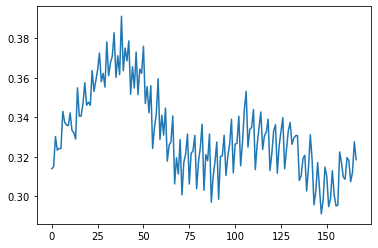

In [278]:
print(utils.one_hot_decode(one_hot_rand[0], order='ATGC'))
plt.plot(res_multi[0])

In [278]:
def swap(one_hot, idx1, idx2):
    idx1, idx2 = np.asarray(idx1), np.asarray(idx2)
    mut = one_hot.copy()
    mut[idx1] = one_hot[idx2]
    mut[idx2] = one_hot[idx1]
    return mut

In [332]:
A = np.array([1, 0, 0, 0])
T = np.array([0, 1, 0, 0])
G = np.array([0, 0, 1, 0])
C = np.array([0, 0, 0, 1])

In [331]:
base = one_hot[1].copy()
print(utils.one_hot_decode(base, order='ATGC'))
mut 
mut = swap(base, [19, 21, 23], [157, 158, 159])
print(utils.one_hot_decode(mut, order='ATGC'))

CCAAAAATCAGATCAAGGGATTGATACAACTAAGATTGAAAATAAGAAAATGAAATTGTGTTACTCTGGTAAATCCTGATGAGCCAAAATTTTTTTTGTTGGGATATGTTTGGATCCTCAGCTGGCCCTTGTTAGAAGAAGGATCTTTCGGAAGCTAGCAATACATT
CCAAAAATCAGATCAAGGGGTCGATACAACTAAGATTGAAAATAAGAAAATGAAATTGTGTTACTCTGGTAAATCCTGATGAGCCAAAATTTTTTTTGTTGGGATATGTTTGGATCCTCAGCTGGCCCTTGTTAGAAGAAGGATCTTTCGGAAGCTAATAATACATT


In [342]:
base = "CCAAAAATCAGATCAAGGGATTGATACAACTAAGATTGAAAATAAGAAAATGAAATTGTGTTACTCTGGTAAATCCTGATGAGCCAAAATTTTTTTTGTTGGGATATGTTTGGATCCTCAGCTGGCCCTTGTTAGAAGAAGGATCTTTCGGAAGCTAGCAATACATT"
mutJ = "CCAAGAATCAGATCAAGGGATTGATACAACTAAGATTGAAAATAAGACAATGAAATTGTGTTACTCTGGTAAATCCTGATGAGCCAAAGTATTCTTTGTTGGGATATGTTTGGATCCTCAGCTGGCCCTTTTTAGACGAAGGATCTTTCGGAAGCTAAAAATACATT"
mutA = "CCAAGAATCAGATCAAGGGATTGATACAACTAAGATCGAGAATAAGACAATGAGATTGTGTGACTCTGGTAGATCCTGATGAGCCAGACTGTCTGTTGTTGAGATATGTTTGGATCCTCAGCTGGCCCTTGTTAGAAGAAGGATCTTTCAAAAAAAAGCAATACATT"
mutB = "CCAAAAATCAGATCAAGGGATTGATACAACTAAGATTGACAATAAGACAATGAGATTGTGTTACTCTGGTACATCCTGATGAGCCAAGATCTGTCTTGTTGGGATATGTGTGGATCCTCAGCTGGCCCTTGTTAGAAGAAGGATCTTTCGGAAGCTAAAAATACATT"

In [341]:
nJ = 0
nA = 0
for a, b, c in zip(base, mutJ, mutA):
    if a != b:
        nJ += 1
    if a != c:
        nA += 1
print(nJ, 'mutations par Julien')
print(nA, 'mutations par Alex')

9 mutations par Julien
18 mutations par Alex


In [337]:
print(len(base), len(mutJ), len(mutA), len(mutB))

167 167 167


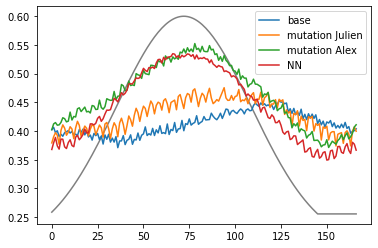

In [348]:
res_base = mid_predict(tile(utils.one_hot_encode(base, order='ATGC'), rlen), model)
res_mutJ = mid_predict(tile(utils.one_hot_encode(mutJ, order='ATGC'), rlen), model)
res_mutA = mid_predict(tile(utils.one_hot_encode(mutA, order='ATGC'), rlen), model)
res_mutB = mid_predict(tile(utils.one_hot_encode(mutB, order='ATGC'), rlen), model)
fig, ax = plt.subplots(1, 1, facecolor='w')
ax.plot(targ, color='grey')
ax.plot(res_base, label='base')
ax.plot(res_mutJ, label='mutation Julien')
ax.plot(res_mutA, label='mutation Alex')
ax.plot(preds[str(rlen)][1000:1000+rlen], label='optimized by NN')
ax.legend()

In [279]:
one_hot_mut = one_hot_rand.copy()
one_hot_mut[:, 154:160] = np.array([1, 0, 0, 0])

In [280]:
res_multi_mut = mid_predict_multi(tile_multi(one_hot_mut, rlen), model)
loss_mut = np_mae_cor(targ, res_multi_mut)
best_mut_idx = np.argmin(loss_mut)

2023-09-25 16:18:18.809251: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 10693344000 exceeds 10% of free system memory.


-0.31669420761626516


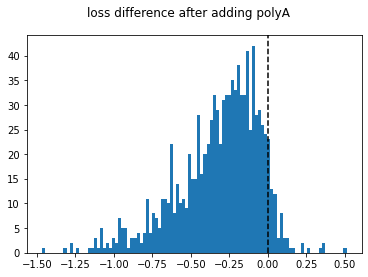

In [281]:
print(np.mean(loss_mut - loss))
fig, ax = plt.subplots(1, 1, facecolor='w')
ax.hist(loss_mut - loss, bins=100)
ax.axvline(x=0, color='k', linestyle='--')
fig.suptitle('loss difference after adding polyA')
plt.show()

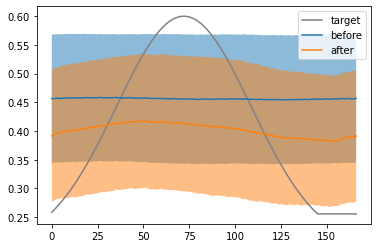

In [282]:
fig, ax = plt.subplots(1, 1, facecolor='w')
ax.plot(targ, color='grey', label='target')
ax.plot(res_multi.mean(axis=0), label='before')
ax.fill_between(np.arange(rlen),
                res_multi.mean(axis=0) - res_multi.std(axis=0),
                res_multi.mean(axis=0) + res_multi.std(axis=0),
                alpha=0.5)
ax.plot(res_multi_mut.mean(axis=0), label='after')
ax.fill_between(np.arange(rlen),
                res_multi_mut.mean(axis=0) - res_multi_mut.std(axis=0),
                res_multi_mut.mean(axis=0) + res_multi_mut.std(axis=0),
                alpha=0.5)
ax.legend()

In [283]:
loss[best_idx], loss_mut[best_mut_idx]

(array([0.11575736]), array([0.09476146]))

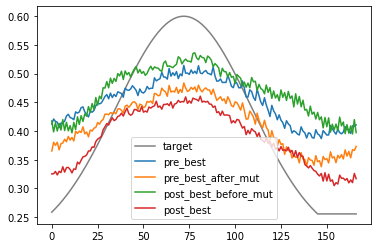

In [284]:
fig, ax = plt.subplots(1, 1, facecolor='w')
ax.plot(targ, color='grey', label='target')
ax.plot(res_multi[best_idx], label='pre_best')
ax.plot(res_multi_mut[best_idx], label='pre_best_after_mut')
ax.plot(res_multi[best_mut_idx], label='post_best_before_mut')
ax.plot(res_multi_mut[best_mut_idx], label='post_best')
ax.legend()

In [64]:
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        if hasattr(o, '__dict__'):
            s += sum(map(sizeof, vars(o)))
        return s

    return sizeof(o)

def print_dict_size_detail(dictionary):
    sizes = sorted([(k, total_size(v)) for k, v in dictionary.items()], key=lambda item: item[1], reverse=True)
    print(sizes)
    print(len(sizes), sum([size for (name, size) in sizes]), end='\n\n')

In [68]:
total_size(locals())

18934761400

: 

In [60]:
# Build a model with random outputs
inp = tf.keras.layers.Input((2001, 4, 1))
out = tf.keras.layers.Lambda(lambda x: tf.random.uniform((tf.shape(x)[0], 1), maxval=1))(inp)
model = tf.keras.Model(inp, out)
model.save('/home/alex/nuc_sequence_design/Results_nucleosome/random_model.hdf5')

In [64]:
model.predict(np.zeros((10, 2001, 4, 1)))

array([[0.20473897],
       [0.9683975 ],
       [0.72970235],
       [0.7316865 ],
       [0.7542199 ],
       [0.12810814],
       [0.3893838 ],
       [0.44834387],
       [0.6306058 ],
       [0.72796047]], dtype=float32)

: 

In [15]:
preds = {}
for k, v in one_hot_repeats.items():
    preds[k] = full_predict_nuc_Etienne(v, model, reverse=False)

In [16]:
# np.savez_compressed(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_repeatsATGC.npz', **preds)
np.savez_compressed(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_justrepeats601ATGC.npz', **preds)

In [344]:
model_name = 'weights_with_rev_compl_rep2'
with np.load(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_justrepeatsATGC.npz') as f:
    preds = {k: f[k] for k in f.keys()}
# with np.load(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_justrepeatsATGC_rev.npz') as f:
#     preds_rev = {k: f[k] for k in f.keys()}

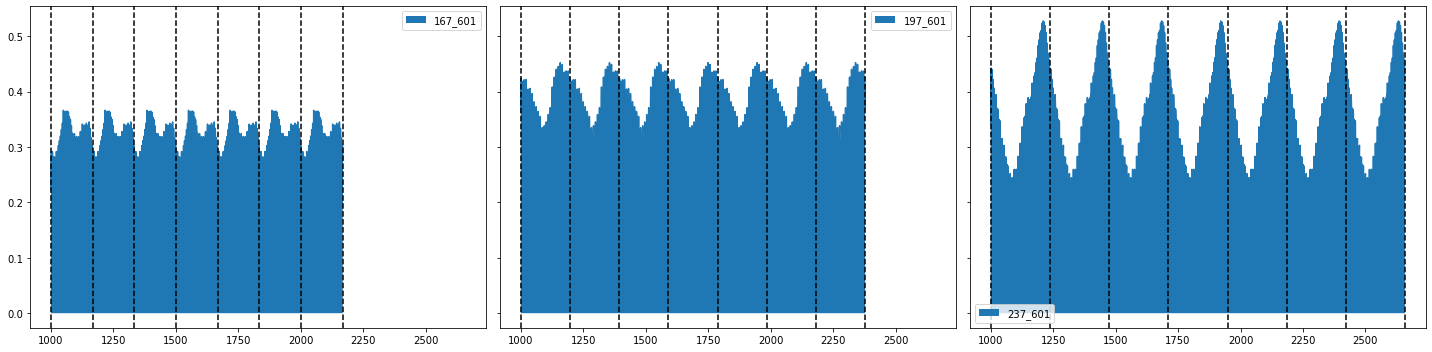

In [27]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, 5), facecolor='w', layout='tight')
# axes[0].set_ylim(0, 1)
for (k, v), ax in zip(preds_rev.items(), axes.flatten()):
    rlen = int(k[:3])
    rstart = 1000
    start = rstart
    stop = rstart + 7*rlen
    ax.plot(np.arange(start, stop), v[start:stop])
    ax.fill_between(np.arange(start, stop), v[start:stop], label=k)
    for reps in range(0, 8):
        ax.axvline(rstart + reps*rlen, color='k', linestyle='--')
    ax.legend()
plt.savefig(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_justrepeats601ATGC_rev.png', bbox_inches='tight')

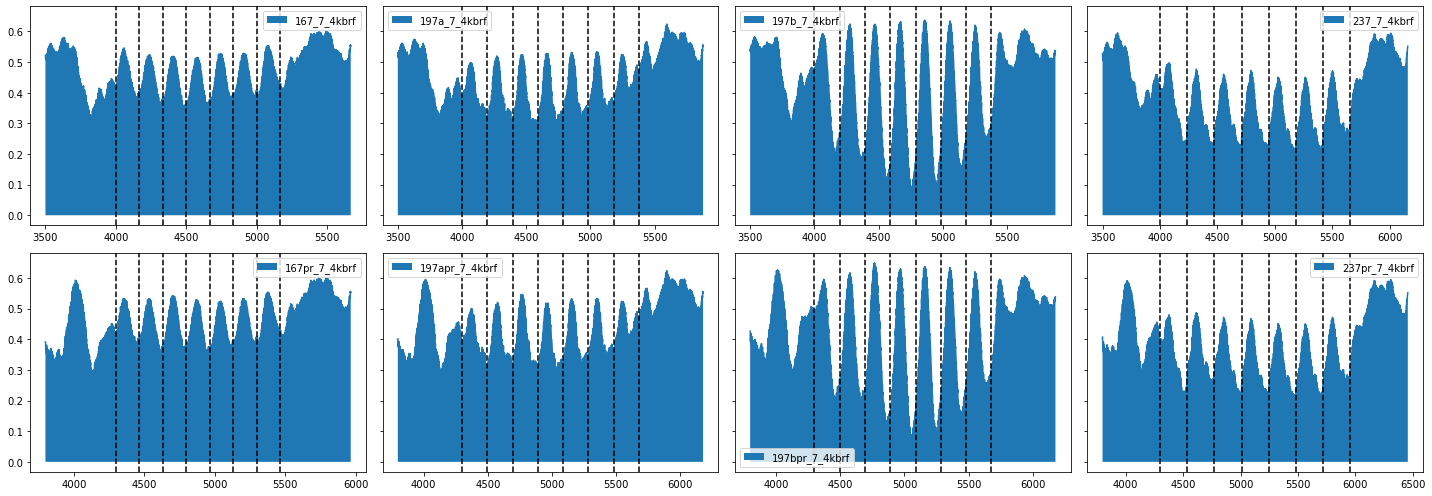

In [82]:
edge = 500
fig, axes = plt.subplots(2, 4, sharey=True, figsize=(20, 7), facecolor='w', layout='tight')
for (k, v), ax in zip(preds.items(), axes.T.flatten()):
    rlen = int(k[:3])
    if 'pr' in k:
        rstart = 4000 + 298
    else:
        rstart = 4000
    start = rstart - edge
    stop = rstart + 7*rlen + edge
    ax.plot(np.arange(start, stop), v[start:stop])
    ax.fill_between(np.arange(start, stop), v[start:stop], label=k)
    for reps in range(0, 8):
        ax.axvline(rstart + reps*rlen, color='k', linestyle='--')
    ax.legend()
plt.savefig(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_repeatsATGC_zoom.png', bbox_inches='tight')

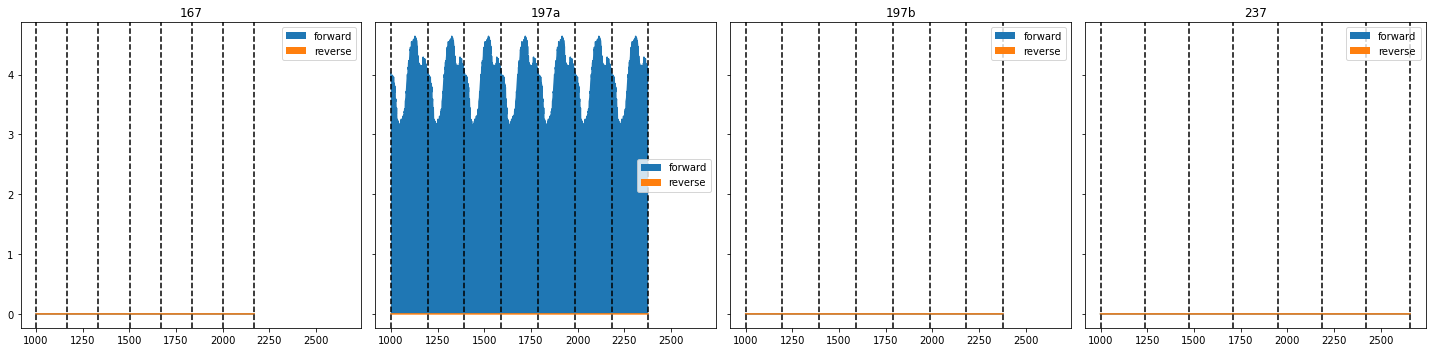

In [13]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 5), facecolor='w', layout='tight')
for (k, v), ax in zip(preds.items(), axes.T.flatten()):
    rlen = int(k[:3])
    rstart = 1000
    start = rstart
    stop = rstart + 7*rlen
    ax.plot(np.arange(start, stop), v[start:stop])
    ax.fill_between(np.arange(start, stop), v[start:stop], label='forward')
    ax.plot(np.arange(start, stop), -preds_rev[k][start:stop])
    ax.fill_between(np.arange(start, stop), -preds_rev[k][start:stop], label='reverse')
    for reps in range(0, 8):
        ax.axvline(rstart + reps*rlen, color='k', linestyle='--')
    ax.legend()
    ax.set_title(k)
plt.savefig(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_justrepeatsATGC_both.png', bbox_inches='tight')

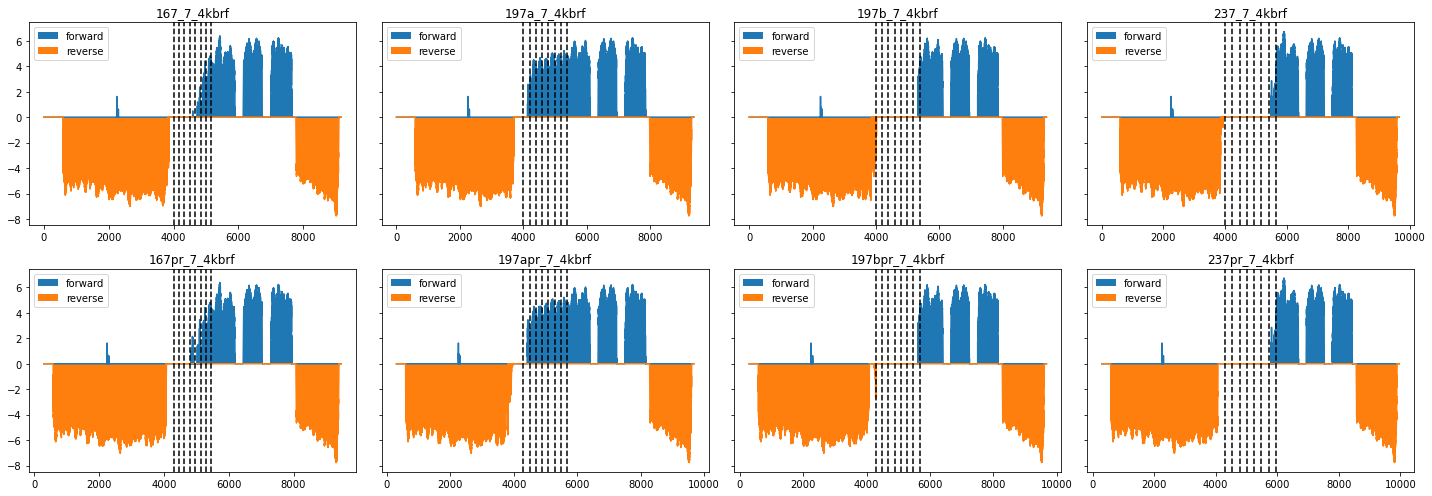

In [11]:
edge = 4000
fig, axes = plt.subplots(2, 4, sharey=True, figsize=(20, 7), facecolor='w', layout='tight')
for (k, v), ax in zip(preds.items(), axes.T.flatten()):
    rlen = int(k[:3])
    if 'pr' in k:
        rstart = 4000 + 298
    else:
        rstart = 4000
    start = rstart - edge
    stop = rstart + 7*rlen + edge
    ax.plot(np.arange(start, stop), v[start:stop])
    ax.fill_between(np.arange(start, stop), v[start:stop], label='forward')
    ax.plot(np.arange(start, stop), -preds_rev[k][start:stop])
    ax.fill_between(np.arange(start, stop), -preds_rev[k][start:stop], label='reverse')
    for reps in range(0, 8):
        ax.axvline(rstart + reps*rlen, color='k', linestyle='--')
    ax.legend()
    ax.set_title(k)
plt.savefig(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_repeatsATGC_both.png', bbox_inches='tight')

In [ ]:
for model_name in ["weight_CNN_RNA_seq_2001_12_8_4_BY4742_rep01",
                   "weight_CNN_RNA_seq_2001_12_8_4_SRR7131299",
                   "weight_CNN_RNA_seq_2001_12_8_4_SRR7131302",
                   "weight_CNN_RNA_seq_trained_on_SRR7131299",
                   "weights_3_replica_v2",
                   "weights_collabo_whole_rep1",
                   "weights_collabo_whole_rep2",
                   "weights_with_rev_compl_rep2",
                   "weights_WT_167_chd1_rep1",
                   "weights_WT_167_chd1_rep2",
                   "weights_WT_167_rep2",
                   "weights_WT_167_rep3",
                   "weights_WT_197_chd1_rep1",
                   "weights_WT_197_chd1_rep2",
                   "weights_WT_237_rep2"]:
    model = tf.keras.models.load_model(f'/home/alex/shared_folder/JB_seqdes/{model_name}.hdf5', custom_objects={'mae_cor': mae_cor, 'correlate': correlate})
    preds = {}
    for k, v in one_hot_repeats.items():
        preds[k] = full_predict_nuc_Etienne(v, model, reverse=True)
    np.savez_compressed(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_justrepeatsATCG_reverse.npz', **preds)
    # with np.load(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_justrepeatsATCG.npz') as f:
    #     preds = {k: f[k] for k in f.keys()}
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 5), facecolor='w', layout='tight')
    if 'CNN' not in model_name:
        axes[0].set_ylim(0, 1)
    for (k, v), ax in zip(preds.items(), axes.T.flatten()):
        rlen = int(k[:3])
        rstart = 1000
        start = rstart
        stop = rstart + 7*rlen
        ax.plot(np.arange(start, stop), v[start:stop])
        ax.fill_between(np.arange(start, stop), v[start:stop], label=k)
        for reps in range(0, 8):
            ax.axvline(rstart + reps*rlen, color='k', linestyle='--')
        ax.legend()
    plt.savefig(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_justrepeatsATCG_reverse.png', bbox_inches='tight')

In [ ]:
for model_name in ["weight_CNN_RNA_seq_2001_12_8_4_BY4742_rep01",
                   "weight_CNN_RNA_seq_2001_12_8_4_SRR7131299",
                   "weight_CNN_RNA_seq_2001_12_8_4_SRR7131302",
                   "weight_CNN_RNA_seq_trained_on_SRR7131299",
                   "weights_3_replica_v2",
                   "weights_collabo_whole_rep1",
                   "weights_collabo_whole_rep2",
                   "weights_with_rev_compl_rep2",
                   "weights_WT_167_chd1_rep1",
                   "weights_WT_167_chd1_rep2",
                   "weights_WT_167_rep2",
                   "weights_WT_167_rep3",
                   "weights_WT_197_chd1_rep1",
                   "weights_WT_197_chd1_rep2",
                   "weights_WT_237_rep2"]:
    # model = tf.keras.models.load_model(f'/home/alex/shared_folder/JB_seqdes/{model_name}.hdf5', custom_objects={'mae_cor': mae_cor, 'correlate': correlate})
    # preds = {}
    # for k, v in one_hots.items():
    #     preds[k] = full_predict_nuc_Etienne(v, model)
    # np.savez_compressed(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_repeatsATCG.npz', **preds)
    with np.load(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_repeatsATCG.npz') as f:
        preds = {k: f[k] for k in f.keys()}
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20, 7), facecolor='w', layout='tight')
    for (k, v), ax in zip(preds.items(), axes.T.flatten()):
        ax.plot(v)
        ax.fill_between(np.arange(0, len(v)), v, label=k)
        ax.legend()
    plt.savefig(f'/home/alex/shared_folder/JB_seqdes/results/preds_{model_name}_on_repeatsATCG_filled.png', bbox_inches='tight')

In [78]:
with np.load(f'/home/alex/shared_folder/JB_seqdes/results/preds_weight_CNN_RNA_seq_2001_12_8_4_SRR7131299_on_repeatsATCG.npz') as f:
    preds = {k: f[k] for k in f.keys()}

In [3]:
species = 'SCerevisiae'
model_name = 'model_myco_pol_17'
with np.load(Path(data_dir, species, 'genome', 'W303_Mmmyco.npz')) as f:
    one_hots_myco = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as f:
    preds_myco_ref = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol_ratio.npz')) as f:
    myco_pol_ratio = {k: f[k] for k in f.keys()}

In [57]:
chr_id = 'Mmmyco'
model = tf.keras.models.load_model(Path(data_dir, species, 'Trainedmodels', model_name, 'model'), custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
pred = tf_utils.predict(model, one_hots_myco[chr_id], 2048, 128, middle=True)

(152576, 16)


In [58]:
np.corrcoef([myco_pol_ratio[chr_id], preds_myco_ref[chr_id], pred])

array([[1.        , 0.11016693, 0.13614929],
       [0.11016693, 1.        , 0.73716236],
       [0.13614929, 0.73716236, 1.        ]])

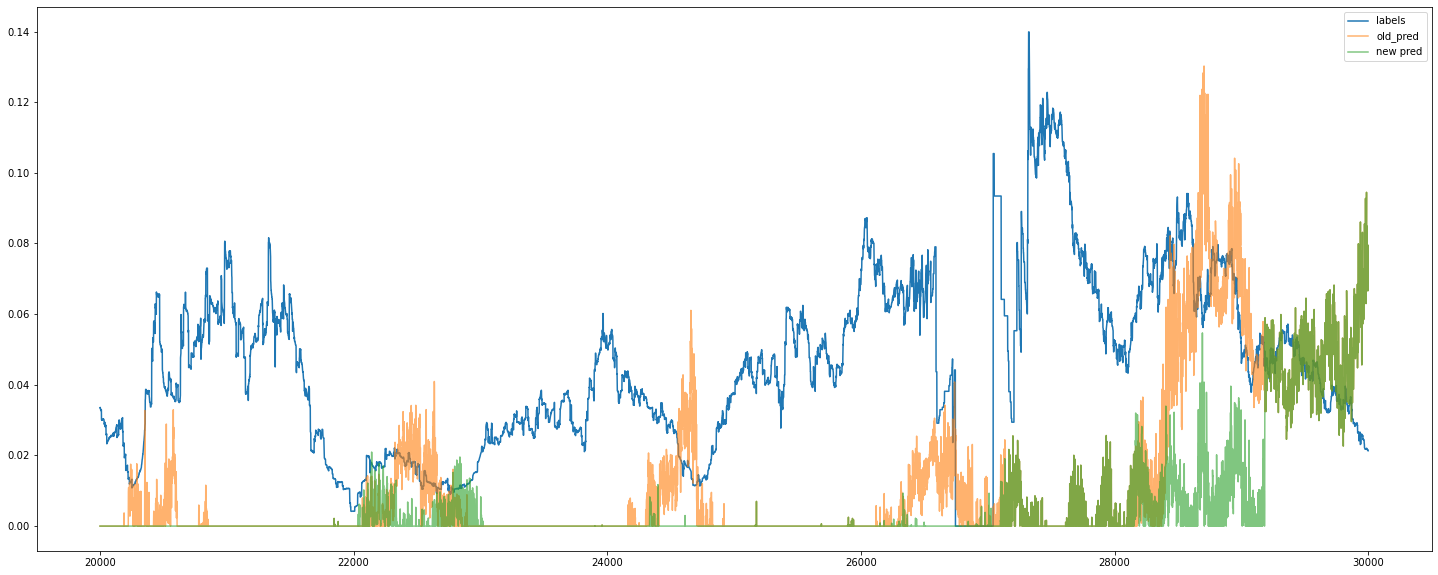

: 

In [63]:
start = 20_000
stop = start + 10_000

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(25, 10), facecolor='w')
stop = min(stop, len(one_hots_myco[chr_id]))
ax.plot(np.arange(start, stop), myco_pol_ratio[chr_id][start:stop], label='labels')
ax.plot(np.arange(start, stop), preds_myco_ref[chr_id][start:stop], label='old_pred', alpha=0.6)
ax.plot(np.arange(start, stop), pred[start:stop], label='new pred', alpha=0.6)
ax.legend()

In [4]:
species = 'SCerevisiae'
with np.load(Path(data_dir, species, 'genome', 'W303_Mmmyco.npz')) as f:
    one_hots = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'genome', 'S288c_Mpneumo.npz')) as f:
    one_hots.update({k: f[k] for k in f.keys()})
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_coh_ratio.npz')) as f:
    labels_coh_ratio = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_coh_ratio.npz')) as f:
    labels_coh_ratio.update({k: f[k] for k in f.keys()})
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol_ratio.npz')) as f:
    labels_pol_ratio = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_pol_ratio.npz')) as f:
    labels_pol_ratio.update({k: f[k] for k in f.keys()})

In [39]:
model_name = 'model_myco_pol_14'
chr_id = 'Mmmyco'
size = 1000
WINDOW = 2048
starts = np.random.choice(len(one_hots[chr_id])-WINDOW, size, replace=False)
indices = starts.reshape(-1, 1) + np.arange(WINDOW).reshape(1, -1)
model = tf.keras.models.load_model(Path(data_dir, species, 'Trainedmodels', model_name, 'model'), custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
sample = one_hots[chr_id][indices].copy()
pred = model.predict(sample)
shuffled = utils.shuffle_along_axis(sample, axis=1)
pred_shuffled = model.predict(shuffled)
print(pred.mean(), pred_shuffled.mean())
print(pred.max(), pred_shuffled.max())

0.025619714 0.03472019
0.26339623 0.26040918


(0.0, 200.0)

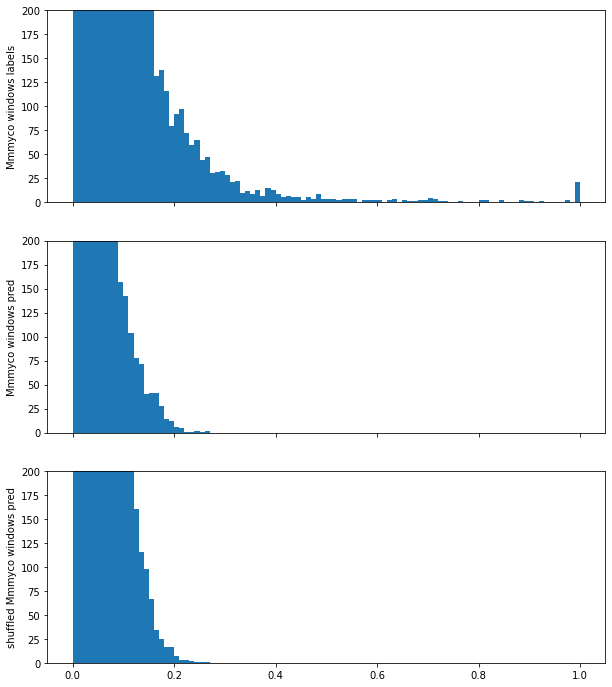

In [42]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 12), facecolor='w')
labs = labels_pol_ratio[chr_id][starts.reshape(-1, 1) + np.arange(0, WINDOW, 128).reshape(1, -1)]
axes[0].hist(labs.ravel(), bins=100, range=(0, 1))
axes[0].set_ylabel(f'{chr_id} windows labels')
axes[1].hist(pred.ravel(), bins=100, range=(0, 1))
axes[1].set_ylabel(f'{chr_id} windows pred')
axes[2].hist(pred_shuffled.ravel(), bins=100, range=(0, 1))
axes[2].set_ylabel(f'shuffled {chr_id} windows pred')
# axes[0].set_ylim(0, 200)
# plt.savefig(Path(data_dir, species, 'results', 'random_seqs', f'distrib_preds_{model_name}_on_{chr_id}_vs_shuffled_and_labels.png'), bbox_inches='tight')

In [6]:
# Predict on random sequences with taylored gc content
species = 'SCerevisiae'
n_gcs = 21
for annotation_type in ['nucleosome', 'cohesine', 'pol']: # ['cohesine']: #
    if annotation_type == 'nucleosome':
        n_seqs = 10000
        model_num = '2_rep3'
        model_files = [Path(data_dir, species, 'Trainedmodels', f'model_myco_nuc_{model_num}', 'model'),
                       Path(data_dir, species, 'Trainedmodels', f'model_pneu_nuc_{model_num}', 'model')]
    elif annotation_type == 'cohesine':
        n_seqs = 32
        model_num = '14_rep3'
        model_files = [Path(data_dir, species, 'Trainedmodels', f'model_myco_coh_{model_num}', 'model'),
                       Path(data_dir, species, 'Trainedmodels', f'model_pneu_coh_{model_num}', 'model')]
    elif annotation_type == 'pol':
        n_seqs = 32
        model_num = '17_rep3'
        model_files = [Path(data_dir, species, 'Trainedmodels', f'model_myco_pol_{model_num}', 'model'),
                       Path(data_dir, species, 'Trainedmodels', f'model_pneu_pol_{model_num}', 'model')]
    one_hots = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'seqs_all_reps_myco_{annotation_type}_random_strictGCrange_indep_{n_seqs}.npy'))
    if annotation_type == 'nucleosome':
        one_hots = one_hots[:, :, 0, [0, 2, 3, 1]]  # from ATCG to ACGT
    preds = []
    for model_file in model_files:
        model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
        pred = model.predict(one_hots).reshape(n_gcs, -1)
        del model
        preds.append(pred)
    preds = np.concatenate(preds, axis=1)
    np.save(Path(data_dir, species, 'results', 'random_seqs', f'preds_myco_pneu_{model_num}_{annotation_type}_random_strictGCrange_indep_{n_seqs}.npy'), preds)

2023-07-16 14:55:45.927690: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13446720000 exceeds 10% of free system memory.
2023-07-16 14:56:02.087723: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13446720000 exceeds 10% of free system memory.


In [10]:
# Generate independent windows for different gc
annotation_type = 'cohesine'
if annotation_type == 'nucleosome':
    n_seqs = 10000
    WINDOW = 2001
    shape = (-1, WINDOW, 4)
    model_files = [Path(data_dir, species, 'Trainedmodels', 'model_myco_nuc_2', 'model'),
                       Path(data_dir, species, 'Trainedmodels', 'model_pneu_nuc_2', 'model')]
else:
    if annotation_type == 'cohesine':
        n_seqs = 100
        WINDOW = 32768
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'Trainedmodels', 'model_myco_coh_14', 'model'),
                       Path(data_dir, species, 'Trainedmodels', 'model_pneu_coh_14', 'model')]
    elif annotation_type == 'pol':
        n_seqs = 100
        WINDOW = 2048
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'Trainedmodels', 'model_myco_pol_17', 'model'),
                       Path(data_dir, species, 'Trainedmodels', 'model_pneu_pol_17', 'model')]
    else:
        raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')

n_gcs = 21
gcs = np.linspace(0, 1, n_gcs)
seqs = []
for gc in gcs:
    seqs.append(utils.random_seq_strict_GC(n_seqs, WINDOW, gc))
seqs = np.concatenate(seqs, axis=0)
one_hots = utils.one_hot_encoding(seqs, read_length=WINDOW, one_hot_type=int).reshape(shape)
np.save(Path(data_dir, species, 'results', 'random_seqs', f'seqs_myco_pneu_{annotation_type}_random_strictGCrange_indep_{n_seqs}.npy'), one_hots)
preds = []
for model_file in model_files:
    model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
    pred = model.predict(one_hots).reshape(n_gcs, -1)
    del model
    preds.append(pred)
preds = np.concatenate(preds, axis=1)
np.save(Path(data_dir, species, 'results', 'random_seqs', f'preds_myco_pneu_14_{annotation_type}_random_strictGCrange_indep_{n_seqs}.npy'), preds)

In [21]:
# Predict on random sequences with taylored gc content
species = 'SCerevisiae'
n_gcs = 21
for annotation_type in ['cohesine']: # ['nucleosome', 'cohesine', 'pol']: #
    if annotation_type == 'nucleosome':
        model_files = [Path(data_dir, species, 'Trainedmodels', 'model_myco_nuc_2', 'model'),
                       Path(data_dir, species, 'Trainedmodels', 'model_pneu_nuc_2', 'model')]
    elif annotation_type == 'cohesine':
        model_files = [Path(data_dir, species, 'Trainedmodels', 'model_myco_coh_14', 'model'),
                       Path(data_dir, species, 'Trainedmodels', 'model_pneu_coh_14', 'model')]
    elif annotation_type == 'pol':
        model_files = [Path(data_dir, species, 'Trainedmodels', 'model_myco_pol_17', 'model'),
                       Path(data_dir, species, 'Trainedmodels', 'model_pneu_pol_17', 'model')]
    with np.load(Path(data_dir, species, 'genome', 'W303_Mmmyco.npz')) as f:
        one_hots = utils.chunk_regions(f['Mmmyco'], 32768)
    n_seqs = len(one_hots)
    gcs = utils.GC_content(one_hots)
    preds = []
    for model_file in model_files:
        model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
        pred = model.predict(one_hots).reshape(n_seqs, -1)
        del model
        preds.append(pred)
    preds = np.concatenate(preds, axis=1)
    np.save(Path(data_dir, species, 'results', 'random_seqs', f'preds_myco_pneu_14_{annotation_type}_trueMmmyco_{n_seqs}.npy'), preds)
    np.save(Path(data_dir, species, 'results', 'random_seqs', f'gcs_myco_pneu_{annotation_type}_trueMmmyco_{n_seqs}.npy'), gcs)

: 

In [54]:
species = 'SCerevisiae'
annotation_type = 'pol'
n_seqs = 32
one_hots = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'seqs_all_reps_myco_{annotation_type}_random_strictGCrange_indep_{n_seqs}.npy'))
one_hots.shape

(672, 2048, 4)

In [41]:
importlib.reload(tf_utils)
genome = Path(data_dir, 'SCerevisiae', 'genome', 'S288c_Mpneumo.npz')
labels = Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_pol_log.npz')
remove_indices = Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'invalid_pneu_pol_log.npz')
chrom_train = ['I', 'II', 'III']
chrom_valid = ['XIV', 'XV']

x_train = utils.merge_chroms(chrom_train, genome)
x_valid = utils.merge_chroms(chrom_valid, genome)
y_train = utils.merge_chroms(chrom_train, labels)
y_valid = utils.merge_chroms(chrom_valid, labels)
if remove_indices is not None:
    with np.load(remove_indices) as f:
        with np.load(labels) as s:
            remove_indices_train, remove_indices_valid = [], []
            total_len_train, total_len_valid = 0, 0
            for k in chrom_train:
                remove_indices_train.append(f[k] + total_len_train)
                total_len_train += len(s[k]) + 1
            remove_indices_train = np.concatenate(remove_indices_train)
            for k in chrom_valid:
                remove_indices_valid.append(f[k] + total_len_valid)
                total_len_valid += len(s[k]) + 1
            remove_indices_valid = np.concatenate(remove_indices_valid)
gen = tf_utils.WindowGenerator(
    data=x_train,
    labels=y_train,
    winsize=2048,
    batch_size=1024,
    max_data=200000,
    n_classes=500,
    balance='batch',
    shuffle=False,
    same_samples=False,
    head_interval=128,
    remove_indices=remove_indices_train,
    remove0s=False,
    removeNs=False,
    strand='both',
    seed=0)

In [42]:
with np.load(remove_indices) as f:
    invalid = {k: f[k] for k in f.keys()}
with np.load(labels) as s:
    signals = {k: s[k] for k in s.keys()}
np.all(remove_indices_train[len(invalid['I']):len(invalid['I'])+len(invalid['II'])] - len(signals['I']) - 1 == invalid['II'])

True

In [17]:
remove_indices_train[len(invalid['I']):len(invalid['I'])+len(invalid['II'])], len(signals['I'])

(array([ 230219,  230220,  230221, ..., 1043400, 1043401, 1043402]), 230218)

In [13]:
invalid['II']

array([     0,      1,      2, ..., 813181, 813182, 813183])

In [33]:
gen.weights

array([0., 0., 0., ..., 0., 0., 1.])

In [44]:
len(signals['I']) + len(signals['II']) + len(signals['III']) + 2 - 1359001

1023

In [43]:
gen.indexes

array([   1024,    1025,    1026, ..., 1358999, 1359000, 1359001])

In [29]:
gen.masked_labels[gen.indexes]

0.0

In [50]:
y_eff = gen.masked_labels[gen.indexes].compressed()
np.sum(y_eff)

11833.621099541913

In [54]:
len(gen.indexes), np.sum(gen.weights), np.sum(~gen.masked_labels.mask)

(230217, 181695.0000000001, 181695)

In [64]:
labels = utils.merge_chroms(['' + c for c in ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII']],
                            Path(data_dir, 'SCerevisiae', 'data', 'labels_pneu_nuc.npz'))
q1, q3 = np.quantile(labels, [0.25, 0.75])
print(q1, q3)
h = 2*(q3-q1)/(len(labels)**(1/3))
print(h, 1/h)

0.10000000149011612 0.4000000059604645
0.0028585172083785263 349.8317229187656


In [64]:
x, y, w = gen.__getitem__(0)
w.shape, np.sum(w)

((1024, 1), 137.216)

In [15]:
importlib.reload(models)
model = models.bassenji_Etienne(32768)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32768, 4)]   0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 32768, 32)    1568        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 4096, 32)     0           conv1d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 4096, 32)     128         max_pooling1d_9[0][0]            
____________________________________________________________________________________________

In [16]:
if isinstance(model.layers[0], tf.keras.layers.InputLayer):
    print('input layer')
    print(model.layers[0].input_shape[0][1])
else:
    print(model.layers[0].input_shape[1])

input layer
32768


: 

In [7]:
model = models.mnase_Maxime(2001)
print(model.summary())
del model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 1999, 32)          416       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 999, 32)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 999, 32)           128       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 990, 32)           10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 495, 32)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 495, 32)           128       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 476, 32)           2

In [3]:
with np.load(Path(data_dir, 'SCerevisiae', 'genome', 'W303', 'W303.npz')) as f:
    x_train = f['chr02']
    x_valid = f['chr14']
    x_test = f['chr16']
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz')) as f:
    y_train = f['chr02']
    y_valid = f['chr14']
    y_test = f['chr16']
x_train.shape

(844051, 4)

In [6]:
def valid_windows(one_hot_chr, labels, winsize):
    N_mask = (np.sum(one_hot_chr, axis=1) == 0)
    N_window_mask = np.asarray(
        np.convolve(N_mask, np.ones(winsize), mode='same'),
        dtype=int)
    valid_window_mask = (N_window_mask == 0) & (labels != 0).ravel()
    indexes = np.arange(len(one_hot_chr))[valid_window_mask]
    indexes = indexes[
        (indexes >= winsize // 2)
        & (indexes < len(one_hot_chr) - (winsize // 2))]
    return indexes

In [7]:
x_eff = valid_windows(x_valid, y_valid, 2001)
len(x_eff)

764064

In [17]:
gen_x = tf_utils.WindowGenerator(x_valid, y_valid, 2001, 1024, 2**22)
gen_x.max_data

238115

In [15]:
2**20

1048576

In [4]:
def predict(model, one_hot_chr, winsize=2001):
    X = utils.chunk_chr(one_hot_chr, 2001)[1]
    pred = np.zeros(len(one_hot_chr))
    pred[winsize//2:-(winsize//2)] = model.predict(X)[:, 0]
    return pred

In [20]:
preds = {}

In [6]:
data = 'MMusculus'
with np.load(Path(data_dir, data, 'genome', 'mm10.npz')) as f:
    x_test = f['chr3']

In [7]:
model = tf.keras.models.load_model(Path(data_dir, 'MMusculus', 'Trainedmodels', 'model_mnase_mm2', 'model'), custom_objects={"mae_cor": mae_cor, "correlate": correlate})
pred_test1 = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001)
pred_test1_rev = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001, reverse=True)
# print(model.layers[0].input_shape[1])#.input_shape[0][1])
del model

model = tf.keras.models.load_model(Path(data_dir, 'MMusculus', 'Trainedmodels', 'model_mnase_mm3', 'model'), custom_objects={"mae_cor": mae_cor, "correlate": correlate})
pred_test2 = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001)
pred_test2_rev = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001, reverse=True)
del model

2023-04-24 14:47:34.656518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-24 14:47:34.677081: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2023-04-24 14:47:44.813776: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 249.88MiB (rounded to 262012928)requested by op sequential/conv1d/conv1d
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-24 14:47:44.813878: I tensorflow/core/common_runtime/bfc_allocator.cc:991] BFCAllocator dump for GPU_0_bfc
2023-04-24 14:47:44.813909: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (256): 	Total Chunks: 104, Chunks in use: 104. 26.0KiB allocated for chunks. 26.0KiB in use in bin. 5.2Ki

ResourceExhaustedError:  OOM when allocating tensor with shape[1024,32,1,1999] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv1d/conv1d (defined at home/alex/mnhn-internship_DeepCNN_ChIP-seq/Modules/tf_utils.py:647) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_7241]

Function call stack:
predict_function


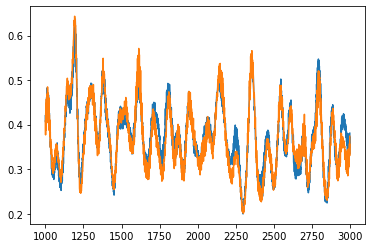

In [74]:
start = 1_000
stop = start + 2_000
plt.plot(np.arange(start, stop), pred_test1[start:stop], label='for_on_for')
plt.plot(np.arange(start, stop), pred_test1_rev[start:stop], label='for_on_rev')
# plt.plot(np.arange(start, stop), pred_test2[start:stop], label='rev_on_for')
# plt.plot(np.arange(start, stop), pred_test2_rev[start:stop], label='rev_on_rev')
plt.show()
plt.close()

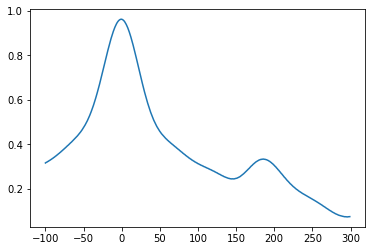

In [75]:
slide_corr = []
offsets = np.arange(-100, 300, 1)
for i in offsets:
    if i == 0:
        corr = pearsonr(pred_test1, pred_test1_rev)[0]
    elif i > 0:
        corr = pearsonr(pred_test1[i:], pred_test1_rev[:-i])[0]
    else:
        corr = pearsonr(pred_test1_rev[-i:], pred_test1[:i])[0]
    slide_corr.append(corr)
plt.plot(offsets, slide_corr)
plt.show()
plt.close()

In [71]:
def sliding_correlation(X, Y, offsets):
    slide_corr = []
    for i in offsets:
        if i == 0:
            corr = pearsonr(X, Y)[0]
        elif i > 0:
            corr = pearsonr(X[i:], Y[:-i])[0]
        else:
            corr = pearsonr(Y[-i:], X[:i])[0]
        slide_corr.append(corr)
    return slide_corr

def fast_sliding_correlation(X, Y, offsets):
    assert len(X) == len(Y)
    min_offset = np.min(offsets)
    max_offset = np.max(offsets)
    max_len = len(X) - max_offset + min_offset
    offsets -= min_offset
    windows = offsets.reshape(-1, 1) + np.arange(max_len).reshape(1, -1)
    X_slides = X[windows]
    slide_corrs = utils.lineWiseCorrcoef(X_slides, Y[-min_offset:-min_offset+max_len])
    return slide_corrs

(400, 99601)


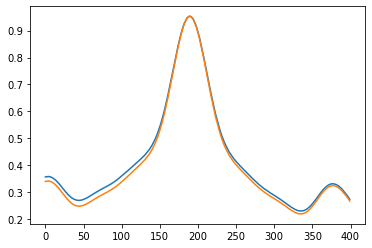

In [68]:
offsets = np.arange(-100, 300)
slide_corrs = sliding_correlation(pred_test1, pred_test1_rev, offsets)
fast_slide_corrs = fast_sliding_correlation(pred_test1, pred_test1_rev, offsets)
plt.plot(offsets, slide_corrs)
plt.plot(offsets, fast_slide_corrs)
plt.show()
plt.close()

In [69]:
%%timeit
sliding_correlation(pred_test1, pred_test1_rev, np.arange(-100, 300))

202 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit
fast_sliding_correlation(pred_test1, pred_test1_rev, np.arange(-100, 300))

221 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# preds['model_mnase_11'] = [pred_test, pred_valid, pred_train, pred_test_rev, pred_valid_rev, pred_train_rev]
# preds['model_mnase_12'] = [pred_test, pred_valid, pred_train, pred_test_rev, pred_valid_rev, pred_train_rev]
preds['model_mnase_13'] = [pred_test, pred_valid, pred_train, pred_test_rev, pred_valid_rev, pred_train_rev]
for pred_model in preds.keys():
    print(pred_model)

model_mnase_11
model_mnase_13


In [19]:
test_corrs = np.corrcoef([y_test, pred_test, pred_test_rev])
valid_corrs = np.corrcoef([y_valid, pred_valid, pred_valid_rev])
train_corrs = np.corrcoef([y_train, pred_train, pred_train_rev])
test_corrs, valid_corrs, train_corrs

(array([[1.        , 0.57081365, 0.5822789 ],
        [0.57081365, 1.        , 0.66006644],
        [0.5822789 , 0.66006644, 1.        ]]),
 array([[1.        , 0.56816693, 0.56442126],
        [0.56816693, 1.        , 0.62536211],
        [0.56442126, 0.62536211, 1.        ]]),
 array([[1.        , 0.8913237 , 0.57227383],
        [0.8913237 , 1.        , 0.62596317],
        [0.57227383, 0.62596317, 1.        ]]))

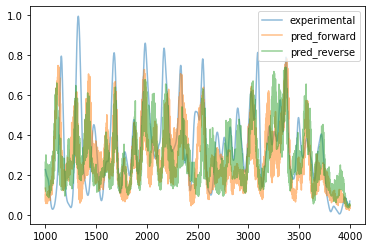

In [25]:
start = 1000
stop = start + 3000 # len(pred_train)
plt.plot(np.arange(start, stop), y_test[start:stop], label='experimental', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test[start:stop], label='pred_forward', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test_rev[start:stop], label='pred_reverse', alpha=0.5)
plt.legend()
plt.show()
plt.close()

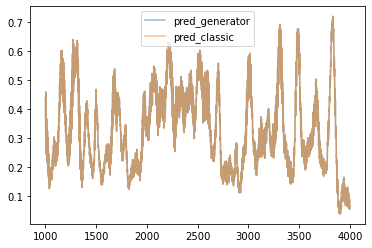

In [36]:
start = 1000
stop = start + 3000 # len(pred_train)
plt.plot(np.arange(start, stop), pred_test_rev[start:stop], label='pred_generator', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test2_rev[start:stop], label='pred_classic', alpha=0.5)
plt.legend()
plt.show()
plt.close()

In [36]:
def merge_chroms(chr_ids, file):
    annot = []
    with np.load(file) as f:
        for chr_id in chr_ids:
            annot.append(f[chr_id])
            shape, dtype = f[chr_id].shape, f[chr_id].dtype
            annot.append(np.zeros((1,)+shape[1:], dtype=dtype))
    return np.concatenate(annot)

In [43]:
a = merge_chroms(['chr01', 'chr02', 'chr03', 'chr04', 'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10', 'chr11', 'chr12', 'chr13'], Path(data_dir, 'SCerevisiae', 'genome', 'W303', 'W303.npz'))
a.shape

(9409640, 4)

In [ ]:
b = merge_chroms(['chr01', 'chr02', 'chr03', 'chr04', 'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10', 'chr11', 'chr12', 'chr13'], Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz'))
b.shape

In [3]:
def correlate(y_true, y_pred):
    """
		Calculate the correlation between the predictions and the labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = correlate)
		>>> load_model('file', custom_objects = {'correlate : correlate})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    return sigma_XY/(sigma_X*sigma_Y + K.epsilon())

def mae_cor(y_true, y_pred):
    """
	   Calculate the mean absolute error minus the correlation between
        predictions and  labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = mae_cor)
		>>> load_model('file', custom_objects = {'mae_cor : mae_cor})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))
    
    return 1 + mae - cor

def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):  
    """ 
        Take a numpy array and return a view of this array after applying a rolling window.

        This takes a numpy and cut it in several pieces with the size, the stride and the 
        axes asked as needed. You may want to use it in order to create a set of sequences
        from an array.

        :param array: The array we want to cut
        :param window: The length of the window
        :param asteps: The stride between two window applied
        :param wsteps: The stride whitin the window
        :param axes: The axe on which to apply the rolling window
        :param toend: Weither or not to finish the cut
        :type array: numpy array
        :type window: int or tuple
        :type asteps: int or tuple
        :type wsteps: int or tuple
        :type axes: int
        :type toend: boolean
        :return: The view of the array
        :rtype: numpy array

        :Example:

        >>> a = numpy.array([0,1,2,3,4,5])
        >>> rolling_window(a, window = 2, asteps = 2, wsteps = None)
        array([[0,1],
               [2,3],
               [4,5]])
        >>> rolling_window(a, window = 2, asteps = None, wsteps = 2)
        array([[0,2],
               [1,3],
               [2,4]
               [3,5]])
        >>> rolling_window(a, window = 5, asteps = 2, wsteps = None)
        array([[0,1,2,3,4]])

        .. warning:: Be carreful about the combination of window, wsteps and asteps that may raise 
                     ValueError. This function forces the window to be of the asked size and thus 
                     may stop the application of the window before the end.
    """        

    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger than 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger than the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any \"old\" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtypenucleotid=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

# Adaptation from Etienne's predict functions for each annotation
def predict(one_hot_chr, model, annotation_type, last_window=True):
    if annotation_type == 'nucleosome':
        WINDOW = 2001
        # X = rolling_window(one_hot_chr, window=(WINDOW, 4))[:, 0, :, None,  :]
        X = utils.sliding_window_view(one_hot_chr, window=(WINDOW, 4)).reshape(-1, WINDOW, 1, 4)
        pred = np.zeros(len(one_hot_chr), dtype='float32')
        pred[WINDOW//2:-(WINDOW//2)] = model.predict(X)[:, 0]
    else:
        if annotation_type == 'cohesine':
            WINDOW = 32768
        elif annotation_type == 'pol':
            WINDOW = 2048
        else:
            raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
        if WINDOW > len(one_hot_chr):
            raise ValueError('sequence too small')
        X = rolling_window(one_hot_chr, window=(WINDOW, 4), asteps=(WINDOW, 4))[:, 0, :, :]
        pred = np.zeros((len(one_hot_chr),))
        y = model.predict(X)
        y = np.repeat(y.ravel(), 128)
        pred[:len(y)] = y
        if last_window:
            X = one_hot_chr[-WINDOW:].reshape((1, WINDOW, 4))
            y = model.predict(X)
            y = np.repeat(y.ravel(), 128)
            leftover = len(pred) % WINDOW
            if leftover != 0:
                pred[-leftover:] = y[-leftover:]
    return pred

# Adaptation to make full predictions
def full_predict(one_hot_chr, model, annotation_type, last_window=True):
    if annotation_type == 'nucleosome':
        WINDOW = 2001
        side_arr = np.zeros_like(one_hot_chr, shape=(WINDOW // 2, 4))
        one_hot_chr = np.vstack([side_arr, one_hot_chr, side_arr])
        X = utils.sliding_window_view(one_hot_chr, window=(WINDOW, 4)).reshape(-1, WINDOW, 1, 4)
        pred = np.zeros(len(one_hot_chr), dtype='float32')
        pred[WINDOW//2:-(WINDOW//2)] = model.predict(X).squeeze()
    else:
        if annotation_type == 'cohesine':
            WINDOW = 32768
        elif annotation_type == 'pol':
            WINDOW = 2048
        else:
            raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
        if WINDOW > len(one_hot_chr):
            raise ValueError('sequence too small')
        head_interval = 128
        X = utils.strided_sliding_window_view(one_hot_chr, (WINDOW, 4), stride=WINDOW, sliding_len=head_interval).reshape(-1, WINDOW, 4)
        pred = np.zeros(len(one_hot_chr), dtype='float32')
        y = model.predict(X).squeeze()
        n_heads = y.shape[-1]
        y = np.transpose(y.reshape(-1, head_interval, n_heads), [0, 2, 1]).ravel()
        pred[:len(y)] = y
        if last_window:
            leftover = len(pred) - len(y)
            if leftover > head_interval - 1:
                X = utils.strided_sliding_window_view(one_hot_chr[-WINDOW-head_interval+1:], (WINDOW, 4), stride=WINDOW, sliding_len=head_interval).squeeze()
                y = model.predict(X).squeeze().T.ravel()
                pred[-leftover:-head_interval+1] = y[-leftover+head_interval-1:]
            return pred
        else:
            return pred, len(y)

In [ ]:
def make_genome_predictions(model_file, genome_file, output_file, annotation_type):
    model = tf.keras.models.load_model(model_file, custom_objects={"mae_cor": mae_cor, "correlate": correlate})
    all_preds = {}
    with np.load(genome_file) as f:
        for chr_id in f.keys():
            one_hot_chr = f[chr_id]
            all_preds[chr_id] = full_predict(one_hot_chr, model, annotation_type)
            all_preds[f'{chr_id}_rev'] = full_predict(one_hot_chr[::-1, ::-1], model, annotation_type)[::-1]
    output_file = utils.safe_filename(output_file)
    np.savez_compressed(output_file, **all_preds)

for model_name, annotation_type in zip(['model_myco_coh_3', 'model_myco_coh_7', 'model_pneu_coh_3', 'model_pneu_coh_7',
                                        'model_myco_pol_3_batch', 'model_myco_pol_7', 'model_pneu_pol_3', 'model_pneu_pol_7'],
                                       ['cohesine', 'cohesine', 'cohesine', 'cohesine',
                                        'pol', 'pol', 'pol', 'pol']):
    print(model_name)
    model_file = Path(data_dir, 'SCerevisiae', 'Trainedmodels', model_name, 'model')
    for genome in ['W303_Mmmyco', 'S288c_Mpneumo']:
        print('\tpredicting on', genome)
        genome_file = Path(data_dir, 'SCerevisiae', 'genome', f'{genome}.npz')
        output_file = Path(data_dir, 'SCerevisiae', 'results', model_name, f'preds_on_{genome}.npz')
        make_genome_predictions(model_file, genome_file, output_file, annotation_type)

In [32]:
# Load one_hots
with np.load(Path(data_dir, 'SCerevisiae', 'genome', 'W303_Mmmyco.npz')) as f:
    one_hots_myco = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'genome', 'S288c_Mpneumo.npz')) as f:
    one_hots_pneu = {k: f[k] for k in f.keys() if k != 'Mito'}

# Load labels
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_myco_coh.npz')) as f:
    myco_coh = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_myco_pol.npz')) as f:
    myco_pol = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_coh.npz')) as f:
    pneu_coh = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_pol.npz')) as f:
    pneu_pol = {k: f[k] for k in f.keys()}

with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_myco_coh_KL.npz')) as f:
    myco_coh_KL = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_myco_pol_KL.npz')) as f:
    myco_pol_KL = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_coh_KL.npz')) as f:
    pneu_coh_KL = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_pol_KL.npz')) as f:
    pneu_pol_KL = {k: f[k] for k in f.keys()}

lens = {'myco': {k: len(v) for k, v in myco_coh.items()},
        'pneu': {k: len(v) for k, v in pneu_coh.items()}}

In [ ]:
model_name = 'model_myco_pol_3_batch'
annot = 'pol' # 'coh' #
preprocessing = '_KL' # '' #
if annot == 'coh' and preprocessing == '_KL':
    labels_myco, labels_pneu = myco_coh_KL, pneu_coh_KL
elif annot == 'coh' and preprocessing == '':
    labels_myco, labels_pneu = myco_coh, pneu_coh
elif annot == 'pol' and preprocessing == '_KL':
    labels_myco, labels_pneu = myco_pol_KL, pneu_pol_KL
elif annot == 'pol' and preprocessing == '':
    labels_myco, labels_pneu = myco_pol, pneu_pol
df_corrs = pd.DataFrame(index=list(one_hots_myco.keys()) + ['Mpneumo'],
                        columns=['W303_Mmmyco', 'W303_Mmmyco_rev', 'S288c_Mpneumo', 'S288c_Mpneumo_rev'])
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
        for chr_id, labels in labels_myco.items():
            df_corrs.loc[chr_id, 'W303_Mmmyco'] = pearsonr(fm[chr_id], labels)[0]
            df_corrs.loc[chr_id, 'W303_Mmmyco_rev'] = pearsonr(fm[f'{chr_id}_rev'], labels)[0]
            if chr_id != 'Mmmyco':
                df_corrs.loc[chr_id, 'S288c_Mpneumo'] = pearsonr(fp[chr_id[3:]], labels_pneu[chr_id[3:]])[0]
                df_corrs.loc[chr_id, 'S288c_Mpneumo_rev'] = pearsonr(fp[f'{chr_id[3:]}_rev'], labels_pneu[chr_id[3:]])[0]
        chr_id = 'Mpneumo'
        df_corrs.loc[chr_id, 'S288c_Mpneumo'] = pearsonr(fp[chr_id], labels_pneu[chr_id])[0]
        df_corrs.loc[chr_id, 'S288c_Mpneumo_rev'] = pearsonr(fp[f'{chr_id}_rev'], labels_pneu[chr_id])[0]
df_corrs.to_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs{preprocessing}'))
df_corrs

In [73]:
model_name = 'model_pneu_coh_3'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_m = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_p = {k: fp[k] for k in fp.keys()}

(0.1880686666434075, 0.0)


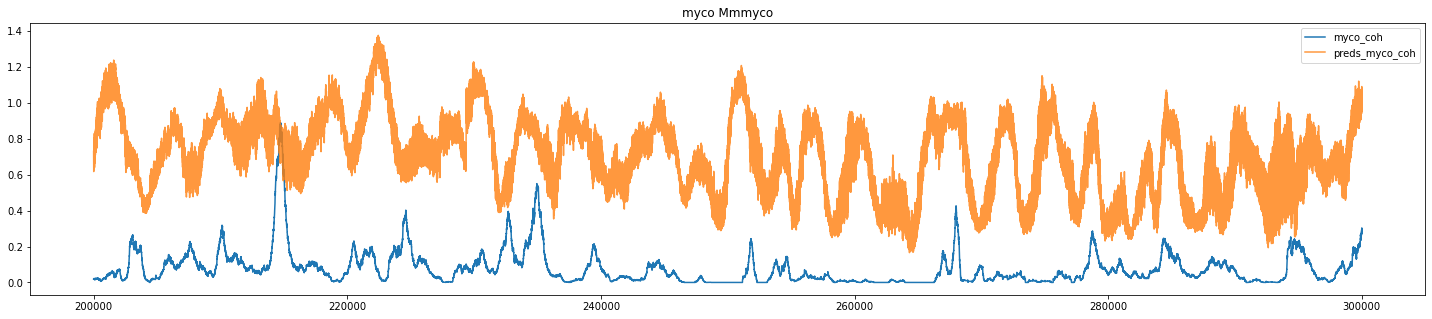

In [82]:
strand = 'myco' # 'pneu' #
chr_id = 'Mmmyco'
start = 200_000
stop = start + 100_000

fig, ax = plt.subplots(1, 1, figsize=(25, 5), facecolor='w')
if strand == 'myco' and chr_id != 'Mmmyco':
    chr_id = 'chr' + chr_id
stop = min(stop, lens[strand][chr_id])

plt.title(f'{strand} {chr_id}')
# ax.plot(np.arange(start, stop), myco_coh[chr_id][start:stop], label='myco_coh')
ax.plot(np.arange(start, stop), myco_coh_KL[chr_id][start:stop], label='myco_coh')
ax.plot(np.arange(start, stop), preds_m[chr_id][start:stop], label='preds_myco_coh', alpha=0.8)

# ax.plot(np.arange(start, stop), myco_pol[chr_id][start:stop], label='myco_pol')
# ax.plot(np.arange(start, stop), myco_pol_KL[chr_id][start:stop], label='myco_pol_KL')
# ax.plot(np.arange(start, stop), preds_m[chr_id][start:stop], label='preds_myco_pol', alpha=0.8)
plt.legend()
print(pearsonr(myco_coh_KL[chr_id][start:stop], preds_m[chr_id][start:stop]))

(0.7553135383872812, 0.0)


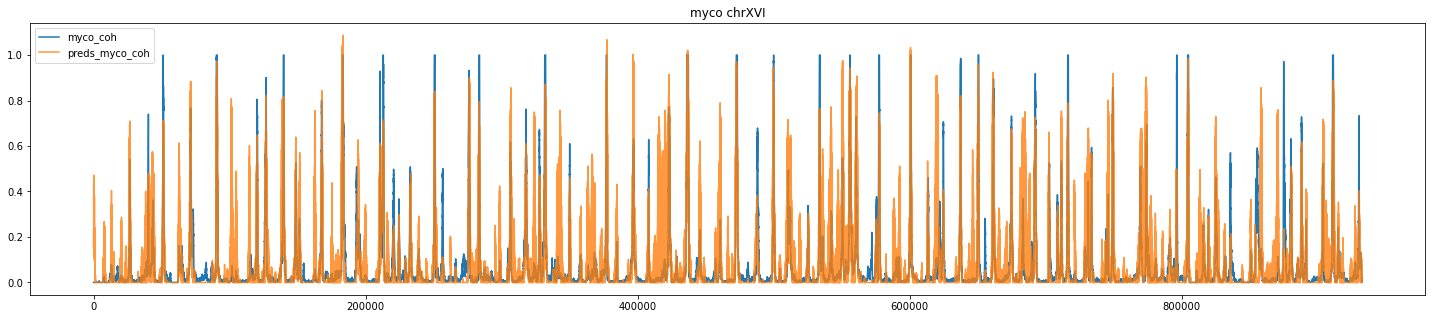

In [80]:
strand = 'myco' # 'pneu' #
chr_id = 'XVI'
start = 000_000
stop = start + 1_000_000

fig, ax = plt.subplots(1, 1, figsize=(25, 5), facecolor='w')
if strand == 'myco' and chr_id != 'Mmmyco':
    chr_id = 'chr' + chr_id
stop = min(stop, lens[strand][chr_id])

plt.title(f'{strand} {chr_id}')
# ax.plot(np.arange(start, stop), myco_coh[chr_id][start:stop], label='myco_coh')
ax.plot(np.arange(start, stop), myco_coh_KL[chr_id][start:stop], label='myco_coh')
ax.plot(np.arange(start, stop), preds_m[chr_id][start:stop], label='preds_myco_coh', alpha=0.8)

# ax.plot(np.arange(start, stop), myco_pol[chr_id][start:stop], label='myco_pol')
# ax.plot(np.arange(start, stop), myco_pol_KL[chr_id][start:stop], label='myco_pol_KL')
# ax.plot(np.arange(start, stop), preds_m[chr_id][start:stop], label='preds_myco_pol', alpha=0.8)
plt.legend()
print(pearsonr(myco_coh_KL[chr_id][start:stop], preds_m[chr_id][start:stop]))

In [26]:
model_name = 'model_pneu_pol_3'
df1 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs_KL'), index_col=0)
df2 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs'), index_col=0)
df_corrs_KL = df1.join(df2, lsuffix='_KL')
df_corrs_KL

,W303_Mmmyco_KL,W303_Mmmyco_rev_KL,S288c_Mpneumo_KL,S288c_Mpneumo_rev_KL,W303_Mmmyco,W303_Mmmyco_rev,S288c_Mpneumo,S288c_Mpneumo_rev
chrI,0.778118,0.717623,0.814402,0.779190,0.714632,0.660440,0.711586,0.688914
chrII,0.606008,0.624445,0.673078,0.695824,0.576533,0.591645,0.614507,0.635473
chrIII,0.730906,0.755172,0.677016,0.564481,0.666838,0.687603,0.624686,0.531420
chrIV,0.673096,0.655601,0.607170,0.608528,0.622579,0.608644,0.552900,0.555872
chrV,0.486120,0.496397,0.512657,0.549151,0.458975,0.467682,0.507079,0.529022
chrVI,0.473498,0.403228,0.438366,0.523341,0.467383,0.415898,0.438253,0.502965
chrVII,0.665991,0.657687,0.595867,0.590182,0.617489,0.613158,0.551839,0.545571
chrVIII,0.557506,0.574818,0.609527,0.600329,0.491971,0.514691,0.556232,0.549221
chrIX,0.654495,0.646553,0.557174,0.518024,0.603160,0.596602,0.496686,0.474298
chrX,0.651669,0.634396,0.567763,0.549890,0.616021,0.603193,0.525457,0.511500


In [29]:
model_name = 'model_myco_pol_7'
df1 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs_KL'), index_col=0)
df2 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs'), index_col=0)
df_corrs = df1.join(df2, lsuffix='_KL')
df_corrs

,W303_Mmmyco_KL,W303_Mmmyco_rev_KL,S288c_Mpneumo_KL,S288c_Mpneumo_rev_KL,W303_Mmmyco,W303_Mmmyco_rev,S288c_Mpneumo,S288c_Mpneumo_rev
chrI,0.797443,0.806631,0.751074,0.768292,0.769238,0.782158,0.669672,0.692196
chrII,0.727367,0.711531,0.613350,0.601384,0.729068,0.712899,0.593685,0.587569
chrIII,0.682555,0.665136,0.545165,0.485107,0.676286,0.644371,0.518189,0.467320
chrIV,0.769490,0.772469,0.570046,0.590372,0.748767,0.749799,0.544276,0.562511
chrV,0.679366,0.672826,0.441846,0.472636,0.668428,0.664125,0.455143,0.486982
chrVI,0.506890,0.595065,0.381788,0.602991,0.547031,0.619664,0.410265,0.577339
chrVII,0.761443,0.724904,0.562735,0.528900,0.748872,0.718587,0.543299,0.513331
chrVIII,0.691136,0.683409,0.555076,0.569974,0.664787,0.663558,0.533264,0.551586
chrIX,0.772817,0.800431,0.538184,0.477078,0.752918,0.768976,0.505794,0.462701
chrX,0.699149,0.709835,0.528640,0.511840,0.697947,0.702000,0.509298,0.492668


In [28]:
df_corrs_KL - df_corrs

,W303_Mmmyco_KL,W303_Mmmyco_rev_KL,S288c_Mpneumo_KL,S288c_Mpneumo_rev_KL,W303_Mmmyco,W303_Mmmyco_rev,S288c_Mpneumo,S288c_Mpneumo_rev
chrI,0.036851,0.030550,0.036864,0.067493,-0.006690,-0.013631,-0.004688,0.020415
chrII,-0.036636,-0.019202,-0.010498,0.029997,-0.075973,-0.055788,-0.052335,-0.015804
chrIII,0.091515,0.092354,0.014298,-0.022422,0.026199,0.030311,-0.022283,-0.051888
chrIV,-0.001864,-0.011170,-0.019821,-0.025302,-0.042925,-0.051884,-0.057399,-0.061923
chrV,-0.022854,-0.008929,-0.023576,-0.015250,-0.052936,-0.041190,-0.048024,-0.054718
chrVI,0.025858,0.049044,-0.010524,0.035453,-0.010092,0.008431,-0.048667,-0.008514
chrVII,-0.001628,-0.011831,-0.022907,-0.017815,-0.042481,-0.047988,-0.052602,-0.050931
chrVIII,-0.015751,-0.011334,-0.013601,-0.046257,-0.055984,-0.048927,-0.050663,-0.082456
chrIX,0.007854,0.013155,-0.008775,-0.014439,-0.027538,-0.007447,-0.053314,-0.035758
chrX,0.025944,0.043639,0.000921,-0.006285,-0.018170,0.002800,-0.038449,-0.042462


In [40]:
for chr_id, labels in myco_pol_KL.items():
    print(chr_id, pearsonr(all_preds[chr_id], labels))

chrI (0.7335456275616082, 0.0)
chrII (0.5883894441610705, 0.0)
chrIII (0.5172738349970311, 0.0)
chrIV (0.5883103469219824, 0.0)
chrV (0.22914877804416117, 0.0)
chrVI (0.26034938414976533, 0.0)
chrVII (0.5925840786070067, 0.0)
chrVIII (0.3677832212251349, 0.0)
chrIX (0.6918413992820829, 0.0)
chrX (0.47085433139240773, 0.0)
chrXI (0.5417987545875256, 0.0)
chrXII (0.47293105669054714, 0.0)
chrXIII (0.5162041741161434, 0.0)
chrXIV (0.4700374196088256, 0.0)
chrXV (0.4732089093045596, 0.0)
chrXVI (0.4415549472611823, 0.0)
Mmmyco (-0.07041125615214144, 0.0)


In [4]:
def log(x):
    x_ = np.copy(x)
    x_[np.isnan(x_)] = 0
    # My preferred way to deal with inf
    x_[np.isinf(x_)] = np.max(x_[np.isfinite(x_)])
    # Workaround Etienne's way to avoid inf in cohesine myco
    # x_[np.isinf(x_)] = np.percentile(x_, 98)
    # Etienne's way
    # x_[np.isinf(x_)] = np.percentile(x_, 99.5)
    # x_[np.isinf(x_)] = np.percentile(x_, 90)
    x_ = np.log2(x_ + 1)
    return x_

def load_yeast_bw(filename, bact='myco', romantoint=False, process=None):
    # Load bigwig
    labels = utils.load_bw(filename)
    # Change chromosome names
    if romantoint:
        for key in list(labels.keys()):
            if key[:3] == 'chr':
                new_key = 'chr' + format(utils.roman_to_int(key[3:]), '02d')
                labels[new_key] = labels.pop(key)
    if bact == 'myco':
        chr_id = list({'Mmm_Linear_740kb.fa', 'Mmmyco'}.intersection(labels.keys()))
        assert len(chr_id) == 1
        labels['myco'] = labels.pop(chr_id[0])
    elif bact == 'pneu':
        labels['pneu'] = labels.pop('Pneu300')
    # Remove unwanted chromosomes
    for key in list(labels.keys()):
        if key[:3] != 'chr' and key != bact:
            labels.pop(key)
    # Transform data
    if process is not None:
        if process == 'conv':
            process = lambda x: utils.moving_average(x, 21, keepsize=True)
        elif process == 'log':
            process = lambda x: np.log2(1 + x)
        for key, value in labels.items():
            labels[key] = process(value)
    # Normalize in CPM
    thres = sum(v.sum() for v in labels.values()) / 1e6
    for key, value in labels.items():
        labels[key] = value / thres
    return labels

def load_yeast_nuc(mycofile=None, pneufile=None, asdict=True, priority='myco', process='conv'):
    if mycofile is None:
        mycofile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM_myco265.bw'
    if pneufile is None:
        pneufile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM_pneumo205.bw'
    # Load bigwigs
    labels_myco = load_yeast_bw(mycofile, bact='myco', process=process)
    labels_pneu = load_yeast_bw(pneufile, bact='pneu', process=process)
    # Get labels from priority file
    labels = {}
    if priority == 'myco':
        for key, value in labels_myco.items():
            labels[key] = value
        labels['pneu'] = labels_pneu['pneu']
    else:
        for key, value in labels_pneu.items():
            labels[key] = value
        labels['myco'] = labels_myco['myco']
    # Return dictionary by chromosome, or an array per genome
    if asdict:
        return labels
    else:
        return (
            np.concatenate([v for k, v in labels.items() if k[:3] == 'chr']),
            labels['myco'],
            labels['pneu']
        )

def load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                    asdict=True, priority='myco'):
    # Get log ratios
    labels_myco = {}
    for key, value in labels_ipmyco.items():
        labels_myco[key] = log(value / labels_ctrlmyco[key])
    thres_myco = sum(v.sum() for v in labels_myco.values()) / 1e6
    labels_pneu = {}
    for key, value in labels_ippneu.items():
        labels_pneu[key] = log(value / labels_ctrlpneu[key])
    thres_pneu = sum(v.sum() for v in labels_pneu.values()) / 1e6
    # Get labels from priority file, and normalize in CPM
    labels = {}
    if priority == 'myco':
        for key, value in labels_myco.items():
            labels[key] = value / thres_myco
        labels['pneu'] = labels_pneu['pneu'] / thres_pneu
    else:
        for key, value in labels_pneu.items():
            labels[key] = value / thres_pneu
        labels['myco'] = labels_myco['myco'] / thres_myco
    # Return dictionary by chromosome, or an array per genome
    if asdict:
        return labels
    else:
        return (
            np.concatenate([v for k, v in labels.items() if k[:3] == 'chr']),
            labels['myco'],
            labels['pneu']
        )

def load_yeast_coh(mycoipfile=None, mycoctrlfile=None, pneuipfile=None, pneuctrlfile=None,
                   asdict=True, priority='pneu'):
    if mycoipfile is None:
        mycoipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/GSM6703630_Scc1_Mmyco_rep1.CPM.bw'
    if mycoctrlfile is None:
        mycoctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/GSM6703631_Scc1-inp_Mmyco_rep1.CPM.bw'
    if pneuipfile is None:
        pneuipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM219.bw'
    if pneuctrlfile is None:
        pneuctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM220.bw'
    # Load bigwigs
    labels_ipmyco = load_yeast_bw(mycoipfile, bact='myco', romantoint=True)
    labels_ctrlmyco = load_yeast_bw(mycoctrlfile, bact='myco', romantoint=True)
    labels_ippneu = load_yeast_bw(pneuipfile, bact='pneu')
    labels_ctrlpneu = load_yeast_bw(pneuctrlfile, bact='pneu')
    return load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                           asdict=asdict, priority=priority)

def load_yeast_pol(mycoipfile=None, mycoctrlfile=None, pneuipfile=None, pneuctrlfile=None,
                   asdict=True, priority='myco'):
    if mycoipfile is None:
        mycoipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM102.bw'
    if mycoctrlfile is None:
        mycoctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM105.bw'
    if pneuipfile is None:
        pneuipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM154.bw'
    if pneuctrlfile is None:
        pneuctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM155.bw'
    # Load bigwigs
    labels_ipmyco = load_yeast_bw(mycoipfile, bact='myco')
    labels_ctrlmyco = load_yeast_bw(mycoctrlfile, bact='myco')
    labels_ippneu = load_yeast_bw(pneuipfile, bact='pneu')
    labels_ctrlpneu = load_yeast_bw(pneuctrlfile, bact='pneu')
    return load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                           asdict=asdict, priority=priority)

# labels_nuc_yeast, labels_nuc_myco, labels_nuc_pneu = load_yeast_nuc(asdict=False, process=None)
# labels_coh_yeast, labels_coh_myco, labels_coh_pneu = load_yeast_coh(asdict=False)
# labels_pol_yeast, labels_pol_myco, labels_pol_pneu = load_yeast_pol(asdict=False)
labels_nuc = load_yeast_nuc()
labels_coh = load_yeast_coh()
labels_pol = load_yeast_pol()

/tmp/ipykernel_1583890/180740096.py:80: RuntimeWarning: divide by zero encountered in true_divide
  labels_myco[key] = log(value / labels_ctrlmyco[key])
/tmp/ipykernel_1583890/180740096.py:80: RuntimeWarning: invalid value encountered in true_divide
  labels_myco[key] = log(value / labels_ctrlmyco[key])
/tmp/ipykernel_1583890/180740096.py:84: RuntimeWarning: divide by zero encountered in true_divide
  labels_pneu[key] = log(value / labels_ctrlpneu[key])
/tmp/ipykernel_1583890/180740096.py:84: RuntimeWarning: invalid value encountered in true_divide
  labels_pneu[key] = log(value / labels_ctrlpneu[key])


In [5]:
species = 'SCerevisiae'

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_W303.npz')) as f:
    preds_nuc = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Pneu300.npz')) as f:
    preds_nuc['pneu'] = f['chr1']
thres_pred_nm = sum([np.sum(v) for k, v in preds_nuc.items() if k!='pneu']) / 1e6
print(thres_pred_nm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_W303.npz')) as f:
    preds_nuc2 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_Pneu300.npz')) as f:
    preds_nuc2['pneu'] = f['chr1']
thres_pred2_nm = sum([np.sum(v) for k, v in preds_nuc2.items() if k!='pneu']) / 1e6
print(thres_pred2_nm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_W303.npz')) as f:
    preds_nuc3 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_Pneu300.npz')) as f:
    preds_nuc3['pneu'] = f['chr1']
thres_pred3_nm = sum([np.sum(v) for k, v in preds_nuc3.items() if k!='pneu']) / 1e6
print(thres_pred3_nm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_W303_with_last.npz')) as f:
    preds_coh = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_coh['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Pneu300_with_last.npz')) as f:
    preds_coh['pneu'] = f['chr1']
thres_pred_cm = sum([np.sum(v) for k, v in preds_coh.items() if k!='pneu']) / 1e6
print(thres_pred_cm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_W303_with_last.npz')) as f:
    preds_coh2 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_coh2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_Pneu300_with_last.npz')) as f:
    preds_coh2['pneu'] = f['chr1']
thres_pred2_cm = sum([np.sum(v) for k, v in preds_coh2.items() if k!='pneu']) / 1e6
print(thres_pred2_cm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_W303_with_last.npz')) as f:
    preds_coh3 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_coh3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_Pneu300_with_last.npz')) as f:
    preds_coh3['pneu'] = f['chr1']
thres_pred3_cm = sum([np.sum(v) for k, v in preds_coh3.items() if k!='pneu']) / 1e6
print(thres_pred3_cm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_W303_with_last.npz')) as f:
    preds_pol = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_pol['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_Pneu300_with_last.npz')) as f:
    preds_pol['pneu'] = f['chr1']
thres_pred_pm = sum([np.sum(v) for k, v in preds_pol.items() if k!='pneu']) / 1e6
print(thres_pred_pm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_W303_with_last.npz')) as f:
    preds_pol2 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_pol2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_Pneu300_with_last.npz')) as f:
    preds_pol2['pneu'] = f['chr1']
thres_pred2_pm = sum([np.sum(v) for k, v in preds_pol2.items() if k!='pneu']) / 1e6
print(thres_pred2_pm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_W303_with_last.npz')) as f:
    preds_pol3 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_pol3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_Pneu300_with_last.npz')) as f:
    preds_pol3['pneu'] = f['chr1']
thres_pred3_pm = sum([np.sum(v) for k, v in preds_pol3.items() if k!='pneu']) / 1e6
print(thres_pred3_pm)

2.4397877109375
2.3684437265625
2.4556031328125
15.128140497459292
13.782405389259338
14.714640640129089
7.697727021959037
9.267423528263093
9.620498055236816


In [6]:
with np.load('../shared_folder/SCerevisiae/genome/W303/W303.npz') as f:
    one_hots_yeast = {key: f[key] for key in f.keys() if key[:3]=='chr'}
with np.load('../shared_folder/SCerevisiae/genome/bacterie/Mmm_Linear_740kb.npz') as f:
    one_hot_myco = f['chr1']
with np.load('../shared_folder/SCerevisiae/genome/bacterie/Pneu300.npz') as f:
    one_hot_pneu = f['chr1']

In [7]:
model_name = 'weights_myco_rep1_cohesine' # 'weights_myco_pol2_2048_16_3'
preds = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_name}_on_W303_full.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_name}_on_Mmm_Linear_740kb_full.npz')) as f:
    preds['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_name}_on_Pneu300_full.npz')) as f:
    preds['pneu'] = f['chr1']

In [316]:
chr_id = 'chr14'
np.corrcoef([labels_pol[chr_id], preds_pol[chr_id], preds_pol2[chr_id], preds_pol3[chr_id], (preds_pol[chr_id] + preds_pol2[chr_id] + preds_pol3[chr_id]) / 3])[:, 0]

array([1.        , 0.64051676, 0.70745244, 0.7050577 , 0.71947583])

In [302]:
WINDOW = 2048
head_interval = 128
n_heads = WINDOW // 128
temps = {}
for chr_id, pred in preds.items():
    temp_len = ((len(pred) - WINDOW - head_interval + 1) // WINDOW + 1) * head_interval * n_heads
    temp = np.transpose(pred[:temp_len].reshape(-1, n_heads, 128), [0, 2, 1])
    temps[chr_id] = temp

In [303]:
chr_id = 'pneu'
temp_len = temps[chr_id].size
trunc_pred = preds[chr_id].copy()
trunc_pred[temp_len:] = 0

trunc_preds_pol = preds_pol3[chr_id].copy()
trunc_preds_pol[temp_len:] = 0
np.corrcoef([labels_pol[chr_id], preds_pol3[chr_id], trunc_preds_pol, preds[chr_id], trunc_pred])[:, 0]

array([1.        , 0.18516879, 0.18516879, 0.1925391 , 0.19151585])

In [304]:
np.corrcoef([labels_pol[chr_id][:temp_len], preds_pol3[chr_id][:temp_len], trunc_preds_pol[:temp_len], preds[chr_id][:temp_len], trunc_pred[:temp_len]])[:, 0]

array([1.        , 0.18616049, 0.18616049, 0.19250753, 0.19250753])

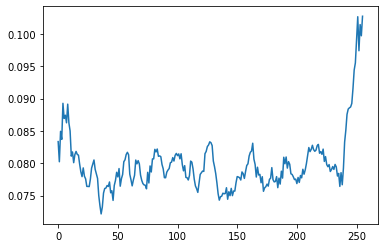

In [237]:
plt.plot(np.mean([np.mean(np.std(temp, axis=1), axis=0) for temp in temps.values()], axis=0))

In [238]:
np.mean([np.mean(np.std(temp, axis=1)) for temp in temps.values()], axis=0), np.mean([np.mean(np.std(temp, axis=2)) for temp in temps.values()], axis=0)

(0.07993876293018973, 0.5890472379804587)

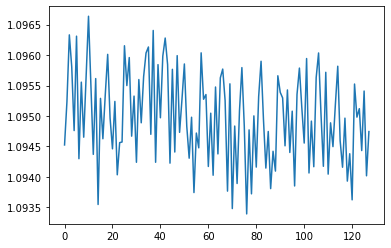

In [245]:
plt.plot(np.mean([np.mean(temp, axis=(0, 2)) for temp in temps.values()], axis=0))

[1.0,
 -0.05998617836891999,
 0.25514203680751935,
 -0.16821651189833972,
 0.03784069122450806,
 -0.19171474021887397,
 0.21699868559762836,
 -0.05885050856678878,
 0.8005205735141387,
 -0.11153211910064262]

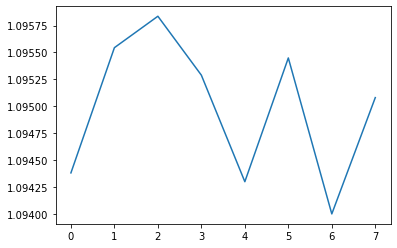

In [250]:
plt.plot(np.mean([np.mean(temp, axis=(0, 2)) for temp in temps.values()], axis=0).reshape(-1, 8).mean(axis=0))

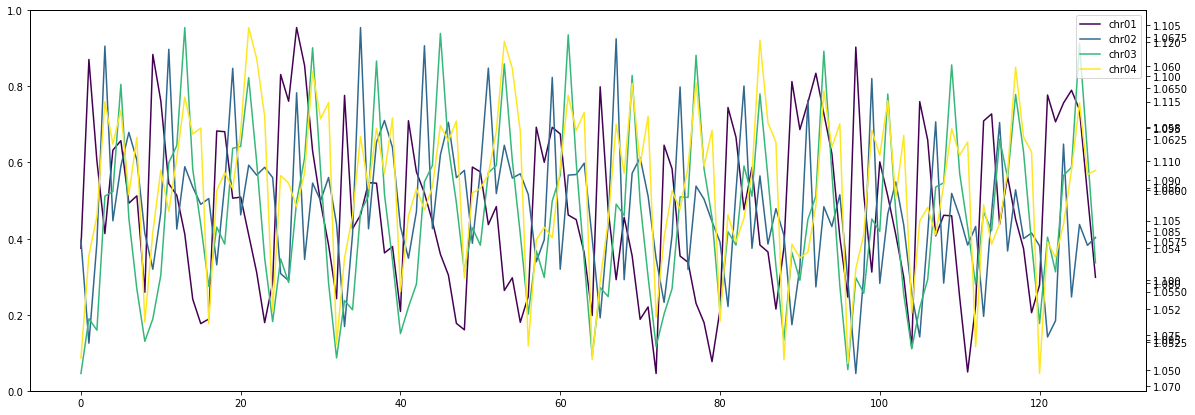

In [249]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
axes = [ax]
chrs = list(temps.keys())[:4] #['chr01', 'chr16', 'myco', 'pneu']
for i, chr_id in enumerate(chrs):
    axes.append(ax.twinx())
    axes[-1].plot(np.mean(temps[chr_id], axis=(0, 2)), label=chr_id, color=mpl.colormaps['viridis'](i / (len(chrs) - 1)))
h, l = plot_utils.add_legend(axes)
plt.legend(h, l)

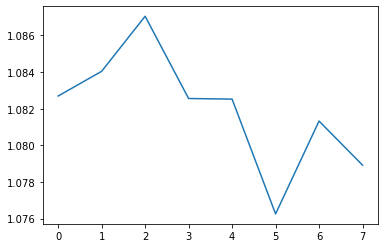

In [229]:
plt.plot(np.mean(temps[chr_id], axis=(0, 2)).reshape(-1, 8).mean(axis=0))

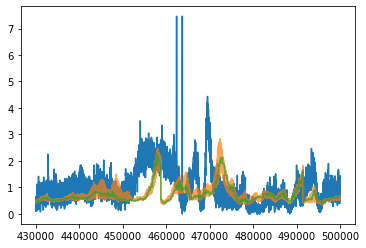

In [25]:
chr_id = 'pneu'
plot_start = 430_000
plot_stop = plot_start + 70_000
plt.plot(np.arange(plot_start, plot_stop), labels_coh[chr_id][plot_start:plot_stop] * thres_pred_cm)
plt.plot(np.arange(plot_start, plot_stop), preds[chr_id][plot_start:plot_stop], alpha=0.7)
plt.plot(np.arange(plot_start, plot_stop), preds_coh[chr_id][plot_start:plot_stop], alpha=0.7)

In [15]:
np.corrcoef([labels_coh[chr_id], preds[chr_id], preds_coh[chr_id]])[:, 0]

array([1.        , 0.42431742, 0.42832975])

In [26]:
np.corrcoef([labels_coh[chr_id][plot_start:plot_stop], preds[chr_id][plot_start:plot_stop], preds_coh[chr_id][plot_start:plot_stop]])[:, 0]

array([1.        , 0.18807992, 0.18046995])

In [12]:
np.corrcoef([labels_coh[chr_id][plot_start:plot_stop], preds[chr_id][plot_start:plot_stop], preds_coh[chr_id][plot_start:plot_stop]])[:, 0]

array([1.        , 0.64693125, 0.63872126])

In [151]:
species = 'SCerevisiae'
genomes = ['W303', 'Mmm_Linear_740kb', 'Pneu300']
model_files = [
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5'), 'nucleosome'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'), 'cohesine'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'), 'cohesine'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5'), 'cohesine'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'), 'pol'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'), 'pol'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5'), 'pol'),
    ]
for model_file, annotation_type in model_files:
    for genome in genomes:
        if annotation_type == 'nucleosome':
            model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
            order_suffix = '_ATCG'
        else:
            model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate})
            order_suffix = ''
        if genome == 'W303':
            genome_dir = 'W303'
        else:
            genome_dir = 'bacterie'
        all_preds = {}
        with np.load(Path(data_dir, species, 'genome', genome_dir, f'{genome}{order_suffix}.npz')) as f:
            for chr_id in f.keys():
                one_hot_chr = f[chr_id]
                try:
                    all_preds[chr_id] = full_predict(one_hot_chr, model, annotation_type, last_window=True)
                except ValueError:
                    print(f"Can't predict on {chr_id}, skipping...")
        del model
        np.savez(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_file.stem}_on_{genome}_full.npz'), **all_preds)

Can't predict on p2, skipping...
Can't predict on p2, skipping...
Can't predict on p2, skipping...
